## Apply noise-diode-based gain corrections to azimuth and raster scans
### A. Ordog, July 2022
### NOTE: please do not modify
#### July 12, 2022: updated to include RR gains, set outlier threshold based on stdev, write out new files with all 4 products corrected
#### July 18, 2022: modified to use polynomial fit to gain vs time rather than interpolation
#### Oct 5, 2022: modified to record corrected scans in noise source units
#### Oct 26, 2022: changed noise source outlier thresholding, added possibility of multiple evening/morning raster scans

In [120]:
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from scipy import interpolate
from operator import itemgetter
from itertools import groupby
from astropy.convolution import convolve, Box1DKernel
import gc

phase = '1'
day ='20'
trim_rast_exist = False
trim_az_exist = True
Nm = 1 # number of morning raster scans
Ne = 1 # number of evening raster scans

#### Change the directory to where the files are located" ####
#dir_in = '/media/ordoga/DVA_data/survey_phase1_day'+day+'/'
#dir_out = '/media/ordoga/DVA_data/survey_phase1_day'+day+'/'
##############################################################

### Use these directories on elephant: ###################
dir_in_rast  = '/srv/data/dva/survey_raster/'
dir_out_rast = '/srv/data/dva/survey_raster_noise_corr/'
dir_in_az    = '/srv/data/dva/survey_azimuth_scans/'
dir_out_az    = '/srv/data/dva/survey_azimuth_scans_noise_corr/'
###########################################################

## Read in files listing start and stop times for azimuth and raster scans:

In [121]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)

raster1_start = []
raster2_start = []
raster1_stop = []
raster2_stop = []

rast_list = ['a','b','c']

# Read in the azimuth scan data and store it in arrays:
with open(dir_in_az+'DVAsurvey_phase'+phase+'_day0'+day+'.txt') as fp:
    for line in fp:       
        scan_id.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
              
for i in range(0,Ne):
    
    if Ne == 1:
        rast1name = 'dva_survey_phase'+phase+'_day0'+day+'_raster1.txt'
    else:
        rast1name = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'.txt'
        
    with open(dir_in_rast+rast1name) as fp:
        for line in fp:  
            raster1_start.append(line.split()[3])
            raster1_stop.append(line.split()[4])
            
for i in range(0,Nm):
    
    if Nm == 1:
        rast2name = 'dva_survey_phase'+phase+'_day0'+day+'_raster2.txt'
    else:
        rast2name = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'.txt'
        
    with open(dir_in_rast+rast2name) as fp:
        for line in fp:  
            raster2_start.append(line.split()[3])
            raster2_stop.append(line.split()[4])
                
print('raster 1:',raster1_start,raster1_stop)
print('')
for i in range(0,len(scan_id)):
    print(f"{scan_id[i]:04}",scan_start[i],scan_stop[i])
print('')
print('raster 2:',raster2_start,raster2_stop)

# Convert start and stop times to Modified Julian Day (MJD).
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd
raster1_start_mjd = Time(raster1_start, format='isot',scale='utc').mjd
raster1_stop_mjd  = Time(raster1_stop,  format='isot',scale='utc').mjd
raster2_start_mjd = Time(raster2_start, format='isot',scale='utc').mjd
raster2_stop_mjd  = Time(raster2_stop,  format='isot',scale='utc').mjd

raster 1: ['2022-06-29T02:31:47.868431'] ['2022-06-29T03:32:08.825613']

0835 2022-06-29T03:51:49.284 2022-06-29T04:09:51.245
2348 2022-06-29T04:14:33.473 2022-06-29T04:32:35.480
1053 2022-06-29T04:37:17.721 2022-06-29T04:55:19.806
1054 2022-06-29T04:57:38.253 2022-06-29T05:15:40.251
1055 2022-06-29T05:17:22.952 2022-06-29T05:35:24.916
2568 2022-06-29T05:40:07.213 2022-06-29T05:58:09.071
1273 2022-06-29T06:03:27.513 2022-06-29T06:21:29.646
1274 2022-06-29T06:23:12.458 2022-06-29T06:41:14.731
1275 2022-06-29T06:42:57.153 2022-06-29T07:00:59.565
1276 2022-06-29T07:03:17.525 2022-06-29T07:21:19.560
1277 2022-06-29T07:23:02.561 2022-06-29T07:41:04.523
2790 2022-06-29T07:45:46.479 2022-06-29T08:03:48.748
0057 2022-06-29T08:09:06.813 2022-06-29T08:27:08.992
1570 2022-06-29T08:31:51.014 2022-06-29T08:49:53.077
1571 2022-06-29T08:51:36.120 2022-06-29T09:09:38.060
0276 2022-06-29T09:14:55.936 2022-06-29T09:32:58.316
0349 2022-06-29T09:36:28.464 2022-06-29T09:54:30.788
0422 2022-06-29T09:58:36.6

## Read in data and stitch together

In [122]:
def concatenate_data(file,RR,LL,reRL,imRL,dec,ra,el,az,t,noise):
    
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    idx1 = len(t)
    
    # Add the position and time data to the corresponding arrays:
    dec = np.concatenate([dec,dataset['metadata']['declination']])
    ra = np.concatenate([ra,dataset['metadata']['right_ascension']])
    el = np.concatenate([el,dataset['metadata']['elevation']])
    az = np.concatenate([az,dataset['metadata']['azimuth']])
    t = np.concatenate([t,dataset['metadata']['utc']])
    noise = np.concatenate([noise,dataset['metadata']['noise_state']])

    idx2 = len(t)
    
    # Add the spectrometer power data to the corresponding arrays:
    RR = np.concatenate([RR,dataset['data'][:,0,:]],axis=0)
    LL = np.concatenate([LL,dataset['data'][:,1,:]],axis=0)
    reRL = np.concatenate([reRL,dataset['data'][:,2,:]],axis=0)
    imRL = np.concatenate([imRL,dataset['data'][:,3,:]],axis=0)
    
    return RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2

In [123]:
%%time

t = []
az = []
dec = []
ra = []
el = []
noise = []
idx1_rast1 = []
idx2_rast1 = []
idx1_rast2 = []
idx2_rast2 = []

# Use one of the scans to get the list of frequencies:
scan0 = f"{scan_id[0]:04}"
file = h5py.File(dir_in_az+'dva_survey_phase'+phase+'_raw_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][:]/1e6

# Create empty arrays for the power data:
RR = np.empty([0,len(freq)])
LL = np.empty([0,len(freq)])
reRL = np.empty([0,len(freq)])
imRL = np.empty([0,len(freq)])

# Raster scan 1:
for i in range(0,Ne):
    if Ne == 1:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+'.h5','r')
    else:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'.h5','r')

    rast1_file_t = [Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                        format='isot',scale='utc').mjd,
                    Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                        format='isot',scale='utc').mjd]
    RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2 = concatenate_data(file,RR,LL,reRL,imRL,
                                                            dec,ra,el,az,t,noise)
    print(idx1,idx2)
    idx1_rast1.append(idx1)
    idx2_rast1.append(idx2)

# Loop through all the scans in the "scan_num" list:
for i in scan_id:
    file = h5py.File(dir_in_az+'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'.h5','r')
    print(i,file)
    RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2 = concatenate_data(file,RR,LL,reRL,imRL,
                                                            dec,ra,el,az,t,noise)
    print(idx1,idx2)
    
# Raster scan 2:
for i in range(0,Nm):
    if Nm == 1:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+'.h5','r')
    else:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'.h5','r')

    rast2_file_t = [Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                        format='isot',scale='utc').mjd,
                    Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                        format='isot',scale='utc').mjd]
    RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2 = concatenate_data(file,RR,LL,reRL,imRL,
                                                            dec,ra,el,az,t,noise)
    print(idx1,idx2)
    idx1_rast2.append(idx1)
    idx2_rast2.append(idx2)

t_set_plt = Time(t, format='isot',scale='utc').mjd

print(RR.shape)
print(t_set_plt.shape)

0 6400
835 <HDF5 file "dva_survey_phase1_raw_0835.h5" (mode r)>
6400 8203
2348 <HDF5 file "dva_survey_phase1_raw_2348.h5" (mode r)>
8203 10007
1053 <HDF5 file "dva_survey_phase1_raw_1053.h5" (mode r)>
10007 11811
1054 <HDF5 file "dva_survey_phase1_raw_1054.h5" (mode r)>
11811 13615
1055 <HDF5 file "dva_survey_phase1_raw_1055.h5" (mode r)>
13615 15418
2568 <HDF5 file "dva_survey_phase1_raw_2568.h5" (mode r)>
15418 17221
1273 <HDF5 file "dva_survey_phase1_raw_1273.h5" (mode r)>
17221 19025
1274 <HDF5 file "dva_survey_phase1_raw_1274.h5" (mode r)>
19025 20829
1275 <HDF5 file "dva_survey_phase1_raw_1275.h5" (mode r)>
20829 22633
1276 <HDF5 file "dva_survey_phase1_raw_1276.h5" (mode r)>
22633 24436
1277 <HDF5 file "dva_survey_phase1_raw_1277.h5" (mode r)>
24436 26239
2790 <HDF5 file "dva_survey_phase1_raw_2790.h5" (mode r)>
26239 28043
57 <HDF5 file "dva_survey_phase1_raw_0057.h5" (mode r)>
28043 29846
1570 <HDF5 file "dva_survey_phase1_raw_1570.h5" (mode r)>
29846 31649
1571 <HDF5 file "dv

In [124]:
print(rast1_file_t)
print(idx1_rast1)
print(idx2_rast1)
print('')
print(rast2_file_t)
print(idx1_rast2)
print(idx2_rast2)
print('')
print(t_set_plt)
t_mean = np.nanmean(t_set_plt)
print(t_mean)

[59759.10434027784, 59759.14877777784]
[0]
[6400]

[59759.5022569445, 59759.5466944445]
[47880]
[54280]

[59759.10434028 59759.10434722 59759.10435417 ... 59759.54668056
 59759.5466875  59759.54669444]
59759.32992716642


## Read in temperature data

In [125]:
def month_to_num(month_name):
    if month_name == 'Jan': month_num = '01'
    if month_name == 'Feb': month_num = '02'
    if month_name == 'Mar': month_num = '03'
    if month_name == 'Apr': month_num = '04'
    if month_name == 'May': month_num = '05'
    if month_name == 'Jun': month_num = '06'
    if month_name == 'Jul': month_num = '07'
    if month_name == 'Aug': month_num = '08'
    if month_name == 'Sep': month_num = '09'
    if month_name == 'Oct': month_num = '10'
    if month_name == 'Nov': month_num = '11'
    if month_name == 'Dec': month_num = '12'
    return(month_num)

i = 0
t_weath = []
temp_C = []

with open('/srv/data/dva/weather_data/weather_survey_phase'+phase+'.txt') as fp:
    for line in fp:
        t_weath.append(str( line.split()[2]+'-'+month_to_num(line.split()[1])+'-'+line.split()[0]+
                  'T'+line.split()[3]))
        temp_C.append(line.split()[4])        

temp_C = np.array(temp_C,dtype=float)
t_weath_fix = Time(t_weath, format='isot',scale='utc')
t_weath_plt = t_weath_fix.mjd

#plt.plot(t_weath_plt,temp_C)

## New code to calculate the power deflection at each noise source instance:

In [126]:
%%time
################################################
# The number of integrations to include on either 
# side of each noise source instance:
n_off = 5
################################################

# Make arrays for noise source deflection:
LL_dnoise = []
RR_dnoise = []
reRL_dnoise = []
imRL_dnoise = []
t_noise = []

wnoise = np.where(noise == 1)[0]
print(wnoise)
for k,g in groupby(enumerate(wnoise),lambda x:x[0]-x[1]):

    try:

        group = np.array(list(map(itemgetter(1),g)))
        #print(group)
        #print(group[1:-1])
        #middle = [group[int(np.floor((len(group)-1)/2))] ,group[int(np.ceil((len(group)-1)/2))]]
        #print(middle)
        offleft = [group[0]-n_off,group[0]-2]
        offright = [group[-1]+2,group[-1]+n_off]
        #print(offleft)
        #print(offright)
        #print('')
    
        LL_noise = np.nanmedian(LL[group[1:-1],:],axis=0)
        LL_off = (np.nanmedian(LL[offleft,:],axis=0) + np.nanmedian(LL[offright,:],axis=0))/2.
    
        RR_noise = np.nanmedian(RR[group[1:-1],:],axis=0)
        RR_off = (np.nanmedian(RR[offleft,:],axis=0) + np.nanmedian(RR[offright,:],axis=0))/2.
    
        reRL_noise = np.nanmedian(reRL[group[1:-1],:],axis=0)
        reRL_off = (np.nanmedian(reRL[offleft,:],axis=0) + np.nanmedian(reRL[offright,:],axis=0))/2.
    
        imRL_noise = np.nanmedian(imRL[group[1:-1],:],axis=0)
        imRL_off = (np.nanmedian(imRL[offleft,:],axis=0) + np.nanmedian(imRL[offright,:],axis=0))/2.
    
        t_noise.append(np.nanmedian(t_set_plt[group[1:-1]]))

        LL_dnoise.append(LL_noise - LL_off)
        RR_dnoise.append(RR_noise - RR_off)
        reRL_dnoise.append(reRL_noise - reRL_off)
        imRL_dnoise.append(imRL_noise - imRL_off)
        
    except:
        pass

LL_dnoise_arr = np.empty([len(LL_dnoise),len(LL_dnoise[0])])
RR_dnoise_arr = np.empty([len(RR_dnoise),len(RR_dnoise[0])])
reRL_dnoise_arr = np.empty([len(reRL_dnoise),len(reRL_dnoise[0])])
imRL_dnoise_arr = np.empty([len(imRL_dnoise),len(imRL_dnoise[0])])

for i in range(0,len(LL_dnoise)):
    LL_dnoise_arr[i,:] = LL_dnoise[i]
    RR_dnoise_arr[i,:] = RR_dnoise[i]
    reRL_dnoise_arr[i,:] = reRL_dnoise[i]
    imRL_dnoise_arr[i,:] = imRL_dnoise[i]

[  172   173   174 ... 54067 54068 54069]
CPU times: user 5.47 s, sys: 317 ms, total: 5.79 s
Wall time: 5.79 s


## Check that the noise source was being fired where expected:

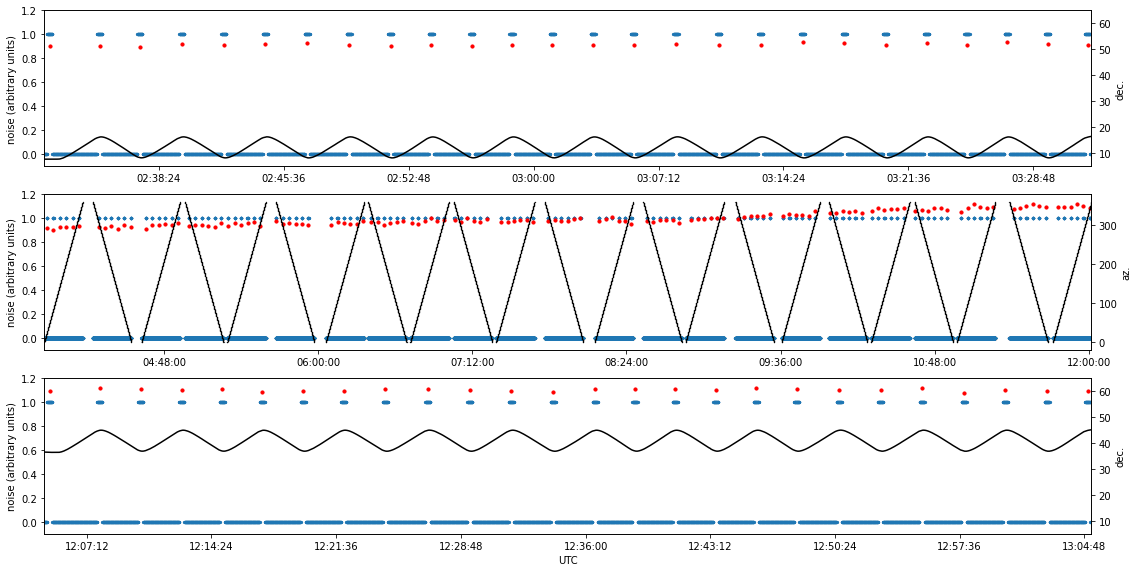

In [127]:
fig1, axs = plt.subplots(3,1,figsize=(16,8))

ii = 7000

axs[0].scatter(t_set_plt,noise,s=5)
axs[0].set_xlim(raster1_start_mjd[0],raster1_stop_mjd[-1])
axs2 = axs[0].twinx()
axs2.plot(t_set_plt,dec,color='k')
axs[0].scatter(t_noise,LL_dnoise_arr[:,ii]/np.nanmean(LL_dnoise_arr[:,ii]),s=10,c='red')
#axs2.set_xlim(raster1_start_mjd,raster1_stop_mjd)
axs2.set_ylim(5,65)
axs2.set_ylabel('dec.')

axs[1].scatter(t_set_plt,noise,s=5)
axs[1].set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
axs2 = axs[1].twinx()
axs2.scatter(t_set_plt,az,color='k',s=0.01)
axs[1].scatter(t_noise,LL_dnoise_arr[:,ii]/np.nanmean(LL_dnoise_arr[:,ii]),s=10,c='red')
#axs2.set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
axs2.set_ylim(-20,380)
axs2.set_ylabel('az.')

axs[2].scatter(t_set_plt,noise,s=5)
axs[2].set_xlim(raster2_start_mjd[0],raster2_stop_mjd[-1])
axs2 = axs[2].twinx()
axs2.plot(t_set_plt,dec,color='k')
axs[2].scatter(t_noise,LL_dnoise_arr[:,ii]/np.nanmean(LL_dnoise_arr[:,ii]),s=10,c='red')
#axs2.set_xlim(raster1_start_mjd,raster1_stop_mjd)
axs2.set_ylim(5,65)
axs2.set_ylabel('dec.')

for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_ylim(-0.1,1.2)
    axs[i].set_ylabel('noise (arbitrary units)')
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_firing_phase'+phase+'_day'+day+'.png')

## Check noise deflection vs frequency for sample noise source instance

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


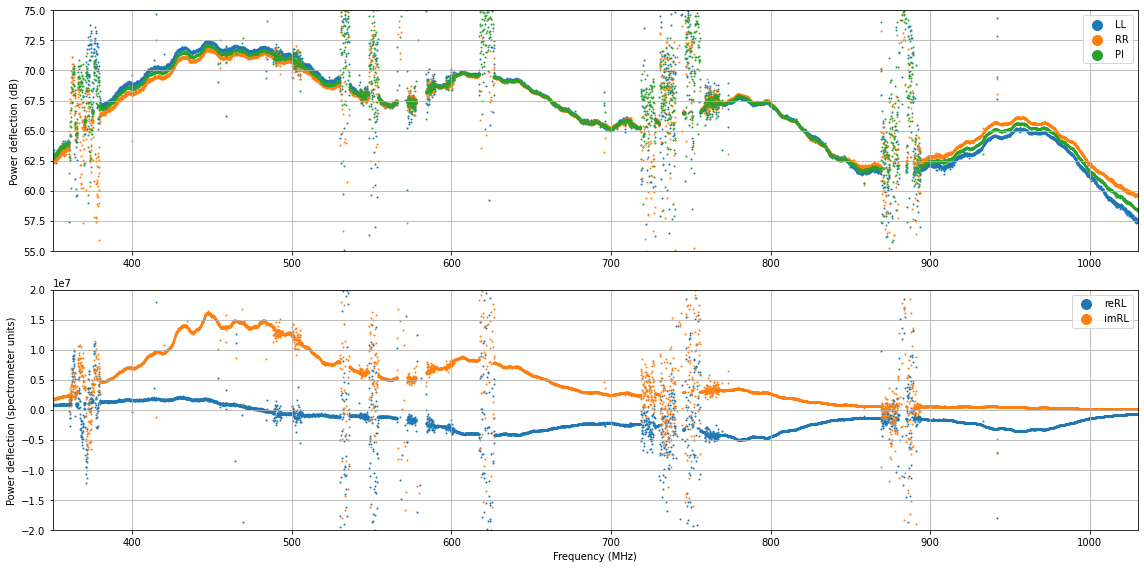

In [128]:
fig1, axs = plt.subplots(2,1,figsize=(16,8))

t_noise_idx = 100

axs[0].scatter(freq,10*np.log10(LL_dnoise_arr[t_noise_idx,:]),s=1,label='LL')
axs[0].scatter(freq,10*np.log10(RR_dnoise_arr[t_noise_idx,:]),s=1,label='RR')
axs[0].scatter(freq,10*np.log10(np.sqrt((reRL_dnoise_arr[t_noise_idx,:])**2 + 
                                        (imRL_dnoise_arr[t_noise_idx,:])**2)),s=1,label='PI')
axs[0].grid()
axs[0].set_ylim(55,75)
axs[0].set_xlim(350,1030)
axs[0].set_ylabel('Power deflection (dB)')
axs[0].legend(markerscale=10)

axs[1].scatter(freq,reRL_dnoise_arr[t_noise_idx,:],s=1,label='reRL')
axs[1].scatter(freq,imRL_dnoise_arr[t_noise_idx,:],s=1,label='imRL')
axs[1].grid()
axs[1].set_ylim(-2e7,2e7)
axs[1].set_xlim(350,1030)
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Power deflection (spectrometer units)')
axs[1].legend(markerscale=10)

plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_power_deflection_vs_freq_phase'+phase+'_day'+day+'.png')

## Remove outliers in noise deflection

In [129]:
%%time
LL_dnoise_fix = LL_dnoise_arr.copy()
RR_dnoise_fix = RR_dnoise_arr.copy()
reRL_dnoise_fix = reRL_dnoise_arr.copy()
imRL_dnoise_fix = imRL_dnoise_arr.copy()
std_mult = 1.0
for i in range(0,len(freq)):
    
    print(i,freq[i])    
    for j in range(0,len(t_noise)):
        
        window = 10
        if ((j >= window) & (j < len(t_noise)-window)):
            LL_near = np.nanmedian(LL_dnoise_arr[j-window:j+window,i])
            RR_near = np.nanmedian(RR_dnoise_arr[j-window:j+window,i])
        else:
            if j < window:
                LL_near = np.nanmedian(LL_dnoise_arr[0:j+window,i])
                RR_near = np.nanmedian(RR_dnoise_arr[0:j+window,i])
            if j >= len(t_noise)-window:
                LL_near = np.nanmedian(LL_dnoise_arr[j-window:-1,i])
                RR_near = np.nanmedian(RR_dnoise_arr[j-window:-1,i])
        
        if ( LL_dnoise_arr[j,i] > 1.1*LL_near):
            LL_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
        if ( LL_dnoise_arr[j,i] < 0.9*LL_near):
            LL_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
            
        if ( RR_dnoise_arr[j,i] > 1.1*RR_near):
            RR_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
        if ( RR_dnoise_arr[j,i] < 0.9*RR_near):
            RR_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan


0 343.77083333333337
1 343.85416666666663
2 343.9375
3 344.02083333333337
4 344.10416666666663
5 344.1875
6 344.27083333333337
7 344.35416666666663
8 344.4375
9 344.52083333333337
10 344.60416666666663
11 344.6875
12 344.77083333333337
13 344.85416666666663
14 344.9375
15 345.02083333333337
16 345.10416666666663
17 345.1875
18 345.27083333333337
19 345.35416666666663
20 345.4375
21 345.52083333333337
22 345.60416666666663
23 345.6875
24 345.77083333333337
25 345.85416666666663
26 345.9375
27 346.02083333333337
28 346.10416666666663
29 346.1875
30 346.27083333333337
31 346.35416666666663
32 346.4375
33 346.52083333333337
34 346.60416666666663
35 346.6875
36 346.77083333333337
37 346.85416666666663
38 346.9375
39 347.02083333333337
40 347.10416666666663
41 347.1875
42 347.27083333333337
43 347.35416666666663
44 347.4375
45 347.52083333333337
46 347.60416666666663
47 347.6875
48 347.77083333333337
49 347.85416666666663
50 347.9375
51 348.02083333333337
52 348.10416666666663
53 348.1875
54

422 378.9375
423 379.02083333333337
424 379.10416666666663
425 379.1875
426 379.27083333333337
427 379.35416666666663
428 379.4375
429 379.52083333333337
430 379.60416666666663
431 379.6875
432 379.77083333333337
433 379.85416666666663
434 379.9375
435 380.02083333333337
436 380.10416666666663
437 380.1875
438 380.27083333333337
439 380.35416666666663
440 380.4375
441 380.52083333333337
442 380.60416666666663
443 380.6875
444 380.77083333333337
445 380.85416666666663
446 380.9375
447 381.02083333333337
448 381.10416666666663
449 381.1875
450 381.27083333333337
451 381.35416666666663
452 381.4375
453 381.52083333333337
454 381.60416666666663
455 381.6875
456 381.77083333333337
457 381.85416666666663
458 381.9375
459 382.02083333333337
460 382.10416666666663
461 382.1875
462 382.27083333333337
463 382.35416666666663
464 382.4375
465 382.52083333333337
466 382.60416666666663
467 382.6875
468 382.77083333333337
469 382.85416666666663
470 382.9375
471 383.02083333333337
472 383.104166666666

851 414.6875
852 414.7708333333333
853 414.85416666666663
854 414.9375
855 415.0208333333333
856 415.10416666666663
857 415.1875
858 415.2708333333333
859 415.35416666666663
860 415.4375
861 415.5208333333333
862 415.60416666666663
863 415.6875
864 415.7708333333333
865 415.85416666666663
866 415.9375
867 416.0208333333333
868 416.10416666666663
869 416.1875
870 416.2708333333333
871 416.35416666666663
872 416.4375
873 416.5208333333333
874 416.60416666666663
875 416.6875
876 416.7708333333333
877 416.85416666666663
878 416.9375
879 417.0208333333333
880 417.10416666666663
881 417.1875
882 417.2708333333333
883 417.35416666666663
884 417.4375
885 417.5208333333333
886 417.60416666666663
887 417.6875
888 417.7708333333333
889 417.85416666666663
890 417.9375
891 418.0208333333333
892 418.10416666666663
893 418.1875
894 418.2708333333333
895 418.35416666666663
896 418.4375
897 418.5208333333333
898 418.60416666666663
899 418.6875
900 418.7708333333333
901 418.85416666666663
902 418.9375
9

1271 449.6875
1272 449.7708333333333
1273 449.85416666666663
1274 449.9375
1275 450.0208333333333
1276 450.10416666666663
1277 450.1875
1278 450.2708333333333
1279 450.35416666666663
1280 450.4375
1281 450.5208333333333
1282 450.60416666666663
1283 450.6875
1284 450.7708333333333
1285 450.85416666666663
1286 450.9375
1287 451.0208333333333
1288 451.10416666666663
1289 451.1875
1290 451.2708333333333
1291 451.35416666666663
1292 451.4375
1293 451.5208333333333
1294 451.60416666666663
1295 451.6875
1296 451.7708333333333
1297 451.85416666666663
1298 451.9375
1299 452.0208333333333
1300 452.10416666666663
1301 452.1875
1302 452.2708333333333
1303 452.35416666666663
1304 452.4375
1305 452.5208333333333
1306 452.60416666666663
1307 452.6875
1308 452.7708333333333
1309 452.85416666666663
1310 452.9375
1311 453.0208333333333
1312 453.10416666666663
1313 453.1875
1314 453.2708333333333
1315 453.35416666666663
1316 453.4375
1317 453.5208333333333
1318 453.60416666666663
1319 453.6875
1320 453.7

1683 484.02083333333337
1684 484.10416666666663
1685 484.1875
1686 484.27083333333337
1687 484.35416666666663
1688 484.4375
1689 484.52083333333337
1690 484.60416666666663
1691 484.6875
1692 484.77083333333337
1693 484.85416666666663
1694 484.9375
1695 485.02083333333337
1696 485.10416666666663
1697 485.1875
1698 485.27083333333337
1699 485.35416666666663
1700 485.4375
1701 485.52083333333337
1702 485.60416666666663
1703 485.6875
1704 485.77083333333337
1705 485.85416666666663
1706 485.9375
1707 486.02083333333337
1708 486.10416666666663
1709 486.1875
1710 486.27083333333337
1711 486.35416666666663
1712 486.4375
1713 486.52083333333337
1714 486.60416666666663
1715 486.6875
1716 486.77083333333337
1717 486.85416666666663
1718 486.9375
1719 487.02083333333337
1720 487.10416666666663
1721 487.1875
1722 487.27083333333337
1723 487.35416666666663
1724 487.4375
1725 487.52083333333337
1726 487.60416666666663
1727 487.6875
1728 487.77083333333337
1729 487.85416666666663
1730 487.9375
1731 488

2090 517.9375
2091 518.0208333333334
2092 518.1041666666667
2093 518.1875
2094 518.2708333333334
2095 518.3541666666667
2096 518.4375
2097 518.5208333333334
2098 518.6041666666667
2099 518.6875
2100 518.7708333333334
2101 518.8541666666667
2102 518.9375
2103 519.0208333333334
2104 519.1041666666667
2105 519.1875
2106 519.2708333333334
2107 519.3541666666667
2108 519.4375
2109 519.5208333333334
2110 519.6041666666667
2111 519.6875
2112 519.7708333333334
2113 519.8541666666667
2114 519.9375
2115 520.0208333333334
2116 520.1041666666667
2117 520.1875
2118 520.2708333333334
2119 520.3541666666667
2120 520.4375
2121 520.5208333333334
2122 520.6041666666667
2123 520.6875
2124 520.7708333333334
2125 520.8541666666667
2126 520.9375
2127 521.0208333333334
2128 521.1041666666667
2129 521.1875
2130 521.2708333333334
2131 521.3541666666667
2132 521.4375
2133 521.5208333333334
2134 521.6041666666667
2135 521.6875
2136 521.7708333333334
2137 521.8541666666667
2138 521.9375
2139 522.0208333333334
214

2504 552.4375
2505 552.5208333333334
2506 552.6041666666667
2507 552.6875
2508 552.7708333333334
2509 552.8541666666667
2510 552.9375
2511 553.0208333333334
2512 553.1041666666667
2513 553.1875
2514 553.2708333333334
2515 553.3541666666667
2516 553.4375
2517 553.5208333333334
2518 553.6041666666667
2519 553.6875
2520 553.7708333333334
2521 553.8541666666667
2522 553.9375
2523 554.0208333333334
2524 554.1041666666667
2525 554.1875
2526 554.2708333333334
2527 554.3541666666667
2528 554.4375
2529 554.5208333333334
2530 554.6041666666667
2531 554.6875
2532 554.7708333333334
2533 554.8541666666667
2534 554.9375
2535 555.0208333333334
2536 555.1041666666667
2537 555.1875
2538 555.2708333333334
2539 555.3541666666667
2540 555.4375
2541 555.5208333333334
2542 555.6041666666667
2543 555.6875
2544 555.7708333333334
2545 555.8541666666667
2546 555.9375
2547 556.0208333333334
2548 556.1041666666667
2549 556.1875
2550 556.2708333333334
2551 556.3541666666667
2552 556.4375
2553 556.5208333333334
255

2914 586.6041666666667
2915 586.6875
2916 586.7708333333334
2917 586.8541666666667
2918 586.9375
2919 587.0208333333334
2920 587.1041666666667
2921 587.1875
2922 587.2708333333334
2923 587.3541666666667
2924 587.4375
2925 587.5208333333334
2926 587.6041666666667
2927 587.6875
2928 587.7708333333334
2929 587.8541666666667
2930 587.9375
2931 588.0208333333334
2932 588.1041666666667
2933 588.1875
2934 588.2708333333334
2935 588.3541666666667
2936 588.4375
2937 588.5208333333334
2938 588.6041666666667
2939 588.6875
2940 588.7708333333334
2941 588.8541666666667
2942 588.9375
2943 589.0208333333334
2944 589.1041666666667
2945 589.1875
2946 589.2708333333334
2947 589.3541666666667
2948 589.4375
2949 589.5208333333334
2950 589.6041666666667
2951 589.6875
2952 589.7708333333334
2953 589.8541666666667
2954 589.9375
2955 590.0208333333334
2956 590.1041666666667
2957 590.1875
2958 590.2708333333334
2959 590.3541666666667
2960 590.4375
2961 590.5208333333334
2962 590.6041666666667
2963 590.6875
296

3328 621.1041666666667
3329 621.1875
3330 621.2708333333333
3331 621.3541666666667
3332 621.4375
3333 621.5208333333333
3334 621.6041666666667
3335 621.6875
3336 621.7708333333333
3337 621.8541666666667
3338 621.9375
3339 622.0208333333333
3340 622.1041666666667
3341 622.1875
3342 622.2708333333333
3343 622.3541666666667
3344 622.4375
3345 622.5208333333333
3346 622.6041666666667
3347 622.6875
3348 622.7708333333333
3349 622.8541666666667
3350 622.9375
3351 623.0208333333333
3352 623.1041666666667
3353 623.1875
3354 623.2708333333333
3355 623.3541666666667
3356 623.4375
3357 623.5208333333333
3358 623.6041666666667
3359 623.6875
3360 623.7708333333333
3361 623.8541666666667
3362 623.9375
3363 624.0208333333333
3364 624.1041666666667
3365 624.1875
3366 624.2708333333333
3367 624.3541666666667
3368 624.4375
3369 624.5208333333333
3370 624.6041666666667
3371 624.6875
3372 624.7708333333333
3373 624.8541666666667
3374 624.9375
3375 625.0208333333333
3376 625.1041666666667
3377 625.1875
337

3741 655.5208333333333
3742 655.6041666666667
3743 655.6875
3744 655.7708333333333
3745 655.8541666666667
3746 655.9375
3747 656.0208333333333
3748 656.1041666666667
3749 656.1875
3750 656.2708333333333
3751 656.3541666666667
3752 656.4375
3753 656.5208333333333
3754 656.6041666666667
3755 656.6875
3756 656.7708333333333
3757 656.8541666666667
3758 656.9375
3759 657.0208333333333
3760 657.1041666666667
3761 657.1875
3762 657.2708333333333
3763 657.3541666666667
3764 657.4375
3765 657.5208333333333
3766 657.6041666666667
3767 657.6875
3768 657.7708333333333
3769 657.8541666666667
3770 657.9375
3771 658.0208333333333
3772 658.1041666666667
3773 658.1875
3774 658.2708333333333
3775 658.3541666666667
3776 658.4375
3777 658.5208333333333
3778 658.6041666666667
3779 658.6875
3780 658.7708333333333
3781 658.8541666666667
3782 658.9375
3783 659.0208333333333
3784 659.1041666666667
3785 659.1875
3786 659.2708333333333
3787 659.3541666666667
3788 659.4375
3789 659.5208333333333
3790 659.60416666

4151 689.6875
4152 689.7708333333334
4153 689.8541666666667
4154 689.9375
4155 690.0208333333334
4156 690.1041666666667
4157 690.1875
4158 690.2708333333334
4159 690.3541666666667
4160 690.4375
4161 690.5208333333334
4162 690.6041666666667
4163 690.6875
4164 690.7708333333334
4165 690.8541666666667
4166 690.9375
4167 691.0208333333334
4168 691.1041666666667
4169 691.1875
4170 691.2708333333334
4171 691.3541666666667
4172 691.4375
4173 691.5208333333334
4174 691.6041666666667
4175 691.6875
4176 691.7708333333334
4177 691.8541666666667
4178 691.9375
4179 692.0208333333334
4180 692.1041666666667
4181 692.1875
4182 692.2708333333334
4183 692.3541666666667
4184 692.4375
4185 692.5208333333334
4186 692.6041666666667
4187 692.6875
4188 692.7708333333334
4189 692.8541666666667
4190 692.9375
4191 693.0208333333334
4192 693.1041666666667
4193 693.1875
4194 693.2708333333334
4195 693.3541666666667
4196 693.4375
4197 693.5208333333334
4198 693.6041666666667
4199 693.6875
4200 693.7708333333334
420

4571 724.6875
4572 724.7708333333334
4573 724.8541666666667
4574 724.9375
4575 725.0208333333334
4576 725.1041666666667
4577 725.1875
4578 725.2708333333334
4579 725.3541666666667
4580 725.4375
4581 725.5208333333334
4582 725.6041666666667
4583 725.6875
4584 725.7708333333334
4585 725.8541666666667
4586 725.9375
4587 726.0208333333334
4588 726.1041666666667
4589 726.1875
4590 726.2708333333334
4591 726.3541666666667
4592 726.4375
4593 726.5208333333334
4594 726.6041666666667
4595 726.6875
4596 726.7708333333334
4597 726.8541666666667
4598 726.9375
4599 727.0208333333334
4600 727.1041666666667
4601 727.1875
4602 727.2708333333334
4603 727.3541666666667
4604 727.4375
4605 727.5208333333334
4606 727.6041666666667
4607 727.6875
4608 727.7708333333334
4609 727.8541666666667
4610 727.9375
4611 728.0208333333334
4612 728.1041666666667
4613 728.1875
4614 728.2708333333334
4615 728.3541666666667
4616 728.4375
4617 728.5208333333334
4618 728.6041666666667
4619 728.6875
4620 728.7708333333334
462

4982 758.9375
4983 759.0208333333333
4984 759.1041666666667
4985 759.1875
4986 759.2708333333333
4987 759.3541666666667
4988 759.4375
4989 759.5208333333333
4990 759.6041666666667
4991 759.6875
4992 759.7708333333333
4993 759.8541666666667
4994 759.9375
4995 760.0208333333333
4996 760.1041666666667
4997 760.1875
4998 760.2708333333333
4999 760.3541666666667
5000 760.4375
5001 760.5208333333333
5002 760.6041666666667
5003 760.6875
5004 760.7708333333333
5005 760.8541666666667
5006 760.9375
5007 761.0208333333333
5008 761.1041666666667
5009 761.1875
5010 761.2708333333333
5011 761.3541666666667
5012 761.4375
5013 761.5208333333333
5014 761.6041666666667
5015 761.6875
5016 761.7708333333333
5017 761.8541666666667
5018 761.9375
5019 762.0208333333333
5020 762.1041666666667
5021 762.1875
5022 762.2708333333333
5023 762.3541666666667
5024 762.4375
5025 762.5208333333333
5026 762.6041666666667
5027 762.6875
5028 762.7708333333333
5029 762.8541666666667
5030 762.9375
5031 763.0208333333333
503

5394 793.2708333333333
5395 793.3541666666667
5396 793.4375
5397 793.5208333333333
5398 793.6041666666667
5399 793.6875
5400 793.7708333333333
5401 793.8541666666667
5402 793.9375
5403 794.0208333333333
5404 794.1041666666667
5405 794.1875
5406 794.2708333333333
5407 794.3541666666667
5408 794.4375
5409 794.5208333333333
5410 794.6041666666667
5411 794.6875
5412 794.7708333333333
5413 794.8541666666667
5414 794.9375
5415 795.0208333333333
5416 795.1041666666667
5417 795.1875
5418 795.2708333333333
5419 795.3541666666667
5420 795.4375
5421 795.5208333333333
5422 795.6041666666667
5423 795.6875
5424 795.7708333333333
5425 795.8541666666667
5426 795.9375
5427 796.0208333333333
5428 796.1041666666667
5429 796.1875
5430 796.2708333333333
5431 796.3541666666667
5432 796.4375
5433 796.5208333333333
5434 796.6041666666667
5435 796.6875
5436 796.7708333333333
5437 796.8541666666667
5438 796.9375
5439 797.0208333333333
5440 797.1041666666667
5441 797.1875
5442 797.2708333333333
5443 797.35416666

5812 828.1041666666667
5813 828.1875
5814 828.2708333333334
5815 828.3541666666667
5816 828.4375
5817 828.5208333333334
5818 828.6041666666667
5819 828.6875
5820 828.7708333333334
5821 828.8541666666667
5822 828.9375
5823 829.0208333333334
5824 829.1041666666667
5825 829.1875
5826 829.2708333333334
5827 829.3541666666667
5828 829.4375
5829 829.5208333333334
5830 829.6041666666667
5831 829.6875
5832 829.7708333333334
5833 829.8541666666667
5834 829.9375
5835 830.0208333333334
5836 830.1041666666667
5837 830.1875
5838 830.2708333333334
5839 830.3541666666667
5840 830.4375
5841 830.5208333333334
5842 830.6041666666667
5843 830.6875
5844 830.7708333333334
5845 830.8541666666667
5846 830.9375
5847 831.0208333333334
5848 831.1041666666667
5849 831.1875
5850 831.2708333333334
5851 831.3541666666667
5852 831.4375
5853 831.5208333333334
5854 831.6041666666667
5855 831.6875
5856 831.7708333333334
5857 831.8541666666667
5858 831.9375
5859 832.0208333333334
5860 832.1041666666667
5861 832.1875
586

6232 863.1041666666667
6233 863.1875
6234 863.2708333333334
6235 863.3541666666667
6236 863.4375
6237 863.5208333333334
6238 863.6041666666667
6239 863.6875
6240 863.7708333333334
6241 863.8541666666667
6242 863.9375
6243 864.0208333333334
6244 864.1041666666667
6245 864.1875
6246 864.2708333333334
6247 864.3541666666667
6248 864.4375
6249 864.5208333333334
6250 864.6041666666667
6251 864.6875
6252 864.7708333333334
6253 864.8541666666667
6254 864.9375
6255 865.0208333333334
6256 865.1041666666667
6257 865.1875
6258 865.2708333333334
6259 865.3541666666667
6260 865.4375
6261 865.5208333333334
6262 865.6041666666667
6263 865.6875
6264 865.7708333333334
6265 865.8541666666667
6266 865.9375
6267 866.0208333333334
6268 866.1041666666667
6269 866.1875
6270 866.2708333333334
6271 866.3541666666667
6272 866.4375
6273 866.5208333333334
6274 866.6041666666667
6275 866.6875
6276 866.7708333333334
6277 866.8541666666667
6278 866.9375
6279 867.0208333333334
6280 867.1041666666667
6281 867.1875
628

6647 897.6875
6648 897.7708333333333
6649 897.8541666666667
6650 897.9375
6651 898.0208333333333
6652 898.1041666666667
6653 898.1875
6654 898.2708333333333
6655 898.3541666666667
6656 898.4375
6657 898.5208333333333
6658 898.6041666666667
6659 898.6875
6660 898.7708333333333
6661 898.8541666666667
6662 898.9375
6663 899.0208333333333
6664 899.1041666666667
6665 899.1875
6666 899.2708333333333
6667 899.3541666666667
6668 899.4375
6669 899.5208333333333
6670 899.6041666666667
6671 899.6875
6672 899.7708333333333
6673 899.8541666666667
6674 899.9375
6675 900.0208333333333
6676 900.1041666666667
6677 900.1875
6678 900.2708333333333
6679 900.3541666666667
6680 900.4375
6681 900.5208333333333
6682 900.6041666666667
6683 900.6875
6684 900.7708333333333
6685 900.8541666666667
6686 900.9375
6687 901.0208333333333
6688 901.1041666666667
6689 901.1875
6690 901.2708333333333
6691 901.3541666666667
6692 901.4375
6693 901.5208333333333
6694 901.6041666666667
6695 901.6875
6696 901.7708333333333
669

7067 932.6875
7068 932.7708333333333
7069 932.8541666666667
7070 932.9375
7071 933.0208333333333
7072 933.1041666666667
7073 933.1875
7074 933.2708333333333
7075 933.3541666666667
7076 933.4375
7077 933.5208333333333
7078 933.6041666666667
7079 933.6875
7080 933.7708333333333
7081 933.8541666666667
7082 933.9375
7083 934.0208333333333
7084 934.1041666666667
7085 934.1875
7086 934.2708333333333
7087 934.3541666666667
7088 934.4375
7089 934.5208333333333
7090 934.6041666666667
7091 934.6875
7092 934.7708333333333
7093 934.8541666666667
7094 934.9375
7095 935.0208333333333
7096 935.1041666666667
7097 935.1875
7098 935.2708333333333
7099 935.3541666666667
7100 935.4375
7101 935.5208333333333
7102 935.6041666666667
7103 935.6875
7104 935.7708333333333
7105 935.8541666666667
7106 935.9375
7107 936.0208333333333
7108 936.1041666666667
7109 936.1875
7110 936.2708333333333
7111 936.3541666666667
7112 936.4375
7113 936.5208333333333
7114 936.6041666666667
7115 936.6875
7116 936.7708333333333
711

7488 967.7708333333334
7489 967.8541666666667
7490 967.9375
7491 968.0208333333334
7492 968.1041666666667
7493 968.1875
7494 968.2708333333334
7495 968.3541666666667
7496 968.4375
7497 968.5208333333334
7498 968.6041666666667
7499 968.6875
7500 968.7708333333334
7501 968.8541666666667
7502 968.9375
7503 969.0208333333334
7504 969.1041666666667
7505 969.1875
7506 969.2708333333334
7507 969.3541666666667
7508 969.4375
7509 969.5208333333334
7510 969.6041666666667
7511 969.6875
7512 969.7708333333334
7513 969.8541666666667
7514 969.9375
7515 970.0208333333334
7516 970.1041666666667
7517 970.1875
7518 970.2708333333334
7519 970.3541666666667
7520 970.4375
7521 970.5208333333334
7522 970.6041666666667
7523 970.6875
7524 970.7708333333334
7525 970.8541666666667
7526 970.9375
7527 971.0208333333334
7528 971.1041666666667
7529 971.1875
7530 971.2708333333334
7531 971.3541666666667
7532 971.4375
7533 971.5208333333334
7534 971.6041666666667
7535 971.6875
7536 971.7708333333334
7537 971.85416666

7908 1002.7708333333334
7909 1002.8541666666667
7910 1002.9375
7911 1003.0208333333334
7912 1003.1041666666667
7913 1003.1875
7914 1003.2708333333334
7915 1003.3541666666667
7916 1003.4375
7917 1003.5208333333334
7918 1003.6041666666667
7919 1003.6875
7920 1003.7708333333334
7921 1003.8541666666667
7922 1003.9375
7923 1004.0208333333334
7924 1004.1041666666667
7925 1004.1875
7926 1004.2708333333334
7927 1004.3541666666667
7928 1004.4375
7929 1004.5208333333334
7930 1004.6041666666667
7931 1004.6875
7932 1004.7708333333334
7933 1004.8541666666667
7934 1004.9375
7935 1005.0208333333334
7936 1005.1041666666667
7937 1005.1875
7938 1005.2708333333334
7939 1005.3541666666667
7940 1005.4375
7941 1005.5208333333334
7942 1005.6041666666667
7943 1005.6875
7944 1005.7708333333334
7945 1005.8541666666667
7946 1005.9375
7947 1006.0208333333334
7948 1006.1041666666667
7949 1006.1875
7950 1006.2708333333334
7951 1006.3541666666667
7952 1006.4375
7953 1006.5208333333334
7954 1006.6041666666667
7955 10

## Calculate fits to noise deflection vs time

In [130]:
%%time
LL_fit = np.empty_like(LL)
RR_fit = np.empty_like(RR)
reRL_fit = np.empty_like(reRL)
imRL_fit = np.empty_like(imRL)

LL_fit_noise_pt = np.empty_like(LL_dnoise_arr)
RR_fit_noise_pt = np.empty_like(RR_dnoise_arr)
reRL_fit_noise_pt = np.empty_like(reRL_dnoise_arr)
imRL_fit_noise_pt = np.empty_like(imRL_dnoise_arr)

for i in range(0,len(freq)):
    print(freq[i])
    try:
        wuse = np.where(np.isfinite(LL_dnoise_fix[:,i]))[0]
        pL = np.polyfit(np.array(t_noise)[wuse]-t_mean,LL_dnoise_fix[wuse,i],9)
        LL_fit[:,i] = np.polyval(pL, t_set_plt-t_mean)
        LL_fit_noise_pt[:,i] = np.polyval(pL, t_noise-t_mean)

        wuse = np.where(np.isfinite(RR_dnoise_fix[:,i]))[0]
        pR = np.polyfit(np.array(t_noise)[wuse]-t_mean,RR_dnoise_fix[wuse,i],9)
        RR_fit[:,i] = np.polyval(pR, t_set_plt-t_mean)
        RR_fit_noise_pt[:,i] = np.polyval(pR, t_noise-t_mean)
    
        wuse = np.where(np.isfinite(reRL_dnoise_fix[:,i]))[0]
        pre = np.polyfit(np.array(t_noise)[wuse]-t_mean,reRL_dnoise_fix[wuse,i],9)
        reRL_fit[:,i] = np.polyval(pre, t_set_plt-t_mean)
        reRL_fit_noise_pt[:,i] = np.polyval(pre, t_noise-t_mean)
    
        wuse = np.where(np.isfinite(imRL_dnoise_fix[:,i]))[0]
        pim = np.polyfit(np.array(t_noise)[wuse]-t_mean,imRL_dnoise_fix[wuse,i],9)
        imRL_fit[:,i] = np.polyval(pim, t_set_plt-t_mean)
        imRL_fit_noise_pt[:,i] = np.polyval(pim, t_noise-t_mean)
    except:
        pass
        


343.77083333333337
343.85416666666663
343.9375
344.02083333333337
344.10416666666663
344.1875
344.27083333333337
344.35416666666663
344.4375
344.52083333333337
344.60416666666663
344.6875
344.77083333333337
344.85416666666663
344.9375
345.02083333333337
345.10416666666663
345.1875
345.27083333333337
345.35416666666663
345.4375
345.52083333333337
345.60416666666663
345.6875
345.77083333333337
345.85416666666663
345.9375
346.02083333333337
346.10416666666663
346.1875
346.27083333333337
346.35416666666663
346.4375
346.52083333333337
346.60416666666663
346.6875
346.77083333333337
346.85416666666663
346.9375
347.02083333333337
347.10416666666663
347.1875
347.27083333333337
347.35416666666663
347.4375
347.52083333333337
347.60416666666663
347.6875
347.77083333333337
347.85416666666663
347.9375
348.02083333333337
348.10416666666663
348.1875
348.27083333333337
348.35416666666663
348.4375
348.52083333333337
348.60416666666663
348.6875
348.77083333333337
348.85416666666663
348.9375
349.020833333

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

362.52083333333337
362.60416666666663
362.6875
362.77083333333337
362.85416666666663
362.9375
363.02083333333337
363.10416666666663
363.1875
363.27083333333337
363.35416666666663
363.4375
363.52083333333337
363.60416666666663
363.6875
363.77083333333337
363.85416666666663
363.9375
364.02083333333337
364.10416666666663
364.1875
364.27083333333337
364.35416666666663
364.4375
364.52083333333337


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

364.60416666666663
364.6875
364.77083333333337
364.85416666666663
364.9375
365.02083333333337
365.10416666666663
365.1875
365.27083333333337
365.35416666666663
365.4375
365.52083333333337
365.60416666666663
365.6875
365.77083333333337
365.85416666666663
365.9375
366.02083333333337
366.10416666666663
366.1875
366.27083333333337
366.35416666666663
366.4375
366.52083333333337
366.60416666666663


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

366.6875
366.77083333333337
366.85416666666663
366.9375
367.02083333333337
367.10416666666663
367.1875
367.27083333333337
367.35416666666663
367.4375
367.52083333333337
367.60416666666663
367.6875
367.77083333333337
367.85416666666663
367.9375
368.02083333333337
368.10416666666663
368.1875
368.27083333333337
368.35416666666663
368.4375
368.52083333333337
368.60416666666663
368.6875


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

368.77083333333337
368.85416666666663
368.9375
369.02083333333337
369.10416666666663
369.1875
369.27083333333337
369.35416666666663
369.4375
369.52083333333337
369.60416666666663
369.6875
369.77083333333337
369.85416666666663
369.9375
370.02083333333337
370.10416666666663
370.1875
370.27083333333337
370.35416666666663
370.4375
370.52083333333337
370.60416666666663
370.6875


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

370.77083333333337
370.85416666666663
370.9375
371.02083333333337
371.10416666666663
371.1875
371.27083333333337
371.35416666666663
371.4375
371.52083333333337
371.60416666666663
371.6875
371.77083333333337
371.85416666666663
371.9375
372.02083333333337
372.10416666666663
372.1875
372.27083333333337
372.35416666666663
372.4375
372.52083333333337
372.60416666666663
372.6875
372.77083333333337


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

372.85416666666663
372.9375
373.02083333333337
373.10416666666663
373.1875
373.27083333333337
373.35416666666663
373.4375
373.52083333333337
373.60416666666663
373.6875
373.77083333333337
373.85416666666663
373.9375
374.02083333333337
374.10416666666663
374.1875
374.27083333333337
374.35416666666663
374.4375
374.52083333333337
374.60416666666663
374.6875
374.77083333333337
374.85416666666663
374.9375
375.02083333333337
375.10416666666663
375.1875
375.27083333333337
375.35416666666663
375.4375
375.52083333333337
375.60416666666663
375.6875
375.77083333333337
375.85416666666663
375.9375
376.02083333333337
376.10416666666663
376.1875
376.27083333333337
376.35416666666663
376.4375
376.52083333333337
376.60416666666663
376.6875
376.77083333333337
376.85416666666663
376.9375


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

377.02083333333337
377.10416666666663
377.1875
377.27083333333337
377.35416666666663
377.4375
377.52083333333337
377.60416666666663
377.6875
377.77083333333337
377.85416666666663
377.9375
378.02083333333337
378.10416666666663
378.1875
378.27083333333337
378.35416666666663
378.4375
378.52083333333337
378.60416666666663
378.6875
378.77083333333337
378.85416666666663
378.9375
379.02083333333337


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

379.10416666666663
379.1875
379.27083333333337
379.35416666666663
379.4375
379.52083333333337
379.60416666666663
379.6875
379.77083333333337
379.85416666666663
379.9375
380.02083333333337
380.10416666666663
380.1875
380.27083333333337
380.35416666666663
380.4375
380.52083333333337
380.60416666666663
380.6875
380.77083333333337
380.85416666666663
380.9375
381.02083333333337
381.10416666666663
381.1875
381.27083333333337
381.35416666666663
381.4375
381.52083333333337
381.60416666666663
381.6875
381.77083333333337
381.85416666666663
381.9375
382.02083333333337
382.10416666666663
382.1875
382.27083333333337
382.35416666666663
382.4375
382.52083333333337
382.60416666666663
382.6875
382.77083333333337
382.85416666666663
382.9375
383.02083333333337
383.10416666666663
383.1875
383.27083333333337
383.35416666666663
383.4375
383.52083333333337
383.60416666666663
383.6875
383.77083333333337
383.85416666666663
383.9375
384.02083333333337
384.10416666666663
384.1875
384.27083333333337
384.354166666

424.6875
424.7708333333333
424.85416666666663
424.9375
425.0208333333333
425.10416666666663
425.1875
425.2708333333333
425.35416666666663
425.4375
425.5208333333333
425.60416666666663
425.6875
425.7708333333333
425.85416666666663
425.9375
426.0208333333333
426.10416666666663
426.1875
426.2708333333333
426.35416666666663
426.4375
426.5208333333333
426.60416666666663
426.6875
426.7708333333333
426.85416666666663
426.9375
427.0208333333333
427.10416666666663
427.1875
427.2708333333333
427.35416666666663
427.4375
427.5208333333333
427.60416666666663
427.6875
427.7708333333333
427.85416666666663
427.9375
428.0208333333333
428.10416666666663
428.1875
428.2708333333333
428.35416666666663
428.4375
428.5208333333333
428.60416666666663
428.6875
428.7708333333333
428.85416666666663
428.9375
429.0208333333333
429.10416666666663
429.1875
429.2708333333333
429.35416666666663
429.4375
429.5208333333333
429.60416666666663
429.6875
429.7708333333333
429.85416666666663
429.9375
430.0208333333333
430.104

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)


451.85416666666663
451.9375
452.0208333333333
452.10416666666663
452.1875
452.2708333333333
452.35416666666663
452.4375
452.5208333333333
452.60416666666663
452.6875
452.7708333333333
452.85416666666663
452.9375
453.0208333333333
453.10416666666663
453.1875
453.2708333333333
453.35416666666663
453.4375
453.5208333333333
453.60416666666663
453.6875
453.7708333333333
453.85416666666663
453.9375
454.0208333333333
454.10416666666663
454.1875
454.2708333333333
454.35416666666663
454.4375
454.5208333333333
454.60416666666663
454.6875
454.7708333333333
454.85416666666663
454.9375
455.0208333333333
455.10416666666663
455.1875
455.2708333333333
455.35416666666663
455.4375
455.5208333333333
455.60416666666663
455.6875
455.7708333333333
455.85416666666663
455.9375


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)


456.0208333333333
456.10416666666663
456.1875
456.2708333333333
456.35416666666663
456.4375
456.5208333333333
456.60416666666663
456.6875
456.7708333333333
456.85416666666663
456.9375
457.0208333333333
457.10416666666663
457.1875
457.2708333333333
457.35416666666663
457.4375
457.5208333333333
457.60416666666663
457.6875
457.7708333333333
457.85416666666663
457.9375
458.0208333333333
458.10416666666663
458.1875
458.2708333333333
458.35416666666663
458.4375
458.5208333333333
458.60416666666663
458.6875
458.7708333333333
458.85416666666663
458.9375
459.0208333333333
459.10416666666663
459.1875
459.2708333333333
459.35416666666663
459.4375
459.5208333333333
459.60416666666663
459.6875
459.7708333333333
459.85416666666663
459.9375
460.0208333333333
460.10416666666663
460.1875
460.2708333333333
460.35416666666663
460.4375
460.5208333333333
460.60416666666663
460.6875
460.7708333333333
460.85416666666663
460.9375
461.0208333333333
461.10416666666663
461.1875
461.2708333333333
461.354166666666

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)


470.5208333333333
470.60416666666663
470.6875
470.7708333333333
470.85416666666663
470.9375
471.0208333333333
471.10416666666663
471.1875
471.2708333333333
471.35416666666663
471.4375
471.5208333333333
471.60416666666663
471.6875
471.7708333333333
471.85416666666663
471.9375
472.0208333333333
472.10416666666663
472.1875
472.2708333333333
472.35416666666663
472.4375
472.5208333333333
472.60416666666663
472.6875
472.7708333333333
472.85416666666663
472.9375
473.0208333333333
473.10416666666663
473.1875
473.2708333333333
473.35416666666663
473.4375
473.5208333333333
473.60416666666663
473.6875
473.7708333333333
473.85416666666663
473.9375
474.0208333333333
474.10416666666663
474.1875
474.2708333333333
474.35416666666663
474.4375
474.5208333333333
474.60416666666663
474.6875
474.7708333333333
474.85416666666663
474.9375
475.0208333333333
475.10416666666663
475.1875
475.2708333333333
475.35416666666663
475.4375
475.5208333333333
475.60416666666663
475.6875
475.7708333333333
475.854166666666

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)


485.10416666666663
485.1875
485.27083333333337
485.35416666666663
485.4375
485.52083333333337
485.60416666666663
485.6875
485.77083333333337
485.85416666666663
485.9375
486.02083333333337
486.10416666666663
486.1875
486.27083333333337
486.35416666666663
486.4375
486.52083333333337
486.60416666666663
486.6875
486.77083333333337
486.85416666666663
486.9375
487.02083333333337
487.10416666666663
487.1875
487.27083333333337
487.35416666666663
487.4375
487.52083333333337
487.60416666666663
487.6875
487.77083333333337
487.85416666666663
487.9375
488.02083333333337
488.10416666666663
488.1875
488.27083333333337
488.35416666666663
488.4375
488.52083333333337
488.60416666666663
488.6875
488.77083333333337
488.85416666666663
488.9375
489.02083333333337
489.10416666666663
489.1875
489.27083333333337
489.35416666666663
489.4375
489.52083333333337
489.60416666666663
489.6875
489.77083333333337
489.85416666666663
489.9375
490.02083333333337
490.10416666666663
490.1875
490.27083333333337
490.354166666

529.8541666666667
529.9375
530.0208333333334
530.1041666666667
530.1875
530.2708333333334
530.3541666666667
530.4375
530.5208333333334
530.6041666666667
530.6875
530.7708333333334
530.8541666666667
530.9375
531.0208333333334
531.1041666666667
531.1875
531.2708333333334
531.3541666666667
531.4375
531.5208333333334
531.6041666666667
531.6875
531.7708333333334
531.8541666666667
531.9375
532.0208333333334
532.1041666666667
532.1875
532.2708333333334
532.3541666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

532.4375
532.5208333333334
532.6041666666667
532.6875
532.7708333333334
532.8541666666667
532.9375
533.0208333333334
533.1041666666667
533.1875
533.2708333333334
533.3541666666667
533.4375
533.5208333333334
533.6041666666667
533.6875
533.7708333333334
533.8541666666667
533.9375
534.0208333333334
534.1041666666667
534.1875
534.2708333333334
534.3541666666667
534.4375
534.5208333333334
534.6041666666667
534.6875
534.7708333333334
534.8541666666667
534.9375
535.0208333333334
535.1041666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

535.1875
535.2708333333334
535.3541666666667
535.4375
535.5208333333334
535.6041666666667
535.6875
535.7708333333334
535.8541666666667
535.9375
536.0208333333334
536.1041666666667
536.1875
536.2708333333334
536.3541666666667
536.4375
536.5208333333334
536.6041666666667
536.6875
536.7708333333334
536.8541666666667
536.9375
537.0208333333334
537.1041666666667
537.1875


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)


537.2708333333334
537.3541666666667
537.4375
537.5208333333334
537.6041666666667
537.6875
537.7708333333334
537.8541666666667
537.9375
538.0208333333334
538.1041666666667
538.1875
538.2708333333334
538.3541666666667
538.4375
538.5208333333334
538.6041666666667
538.6875
538.7708333333334
538.8541666666667
538.9375
539.0208333333334
539.1041666666667
539.1875
539.2708333333334
539.3541666666667
539.4375
539.5208333333334
539.6041666666667
539.6875
539.7708333333334
539.8541666666667
539.9375
540.0208333333334
540.1041666666667
540.1875
540.2708333333334
540.3541666666667
540.4375
540.5208333333334
540.6041666666667
540.6875
540.7708333333334
540.8541666666667
540.9375
541.0208333333334
541.1041666666667
541.1875
541.2708333333334
541.3541666666667
541.4375
541.5208333333334
541.6041666666667
541.6875
541.7708333333334
541.8541666666667
541.9375
542.0208333333334
542.1041666666667
542.1875
542.2708333333334
542.3541666666667
542.4375
542.5208333333334
542.6041666666667
542.6875
542.770833

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

548.9375
549.0208333333334
549.1041666666667
549.1875
549.2708333333334
549.3541666666667
549.4375
549.5208333333334
549.6041666666667
549.6875
549.7708333333334
549.8541666666667
549.9375
550.0208333333334
550.1041666666667
550.1875
550.2708333333334
550.3541666666667
550.4375
550.5208333333334
550.6041666666667
550.6875
550.7708333333334
550.8541666666667
550.9375
551.0208333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

551.1041666666667
551.1875
551.2708333333334
551.3541666666667
551.4375
551.5208333333334
551.6041666666667
551.6875
551.7708333333334
551.8541666666667
551.9375
552.0208333333334
552.1041666666667
552.1875
552.2708333333334
552.3541666666667
552.4375
552.5208333333334
552.6041666666667
552.6875
552.7708333333334
552.8541666666667
552.9375
553.0208333333334
553.1041666666667
553.1875
553.2708333333334
553.3541666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

553.4375
553.5208333333334
553.6041666666667
553.6875
553.7708333333334
553.8541666666667
553.9375
554.0208333333334
554.1041666666667
554.1875
554.2708333333334
554.3541666666667
554.4375
554.5208333333334
554.6041666666667
554.6875
554.7708333333334
554.8541666666667
554.9375
555.0208333333334
555.1041666666667
555.1875
555.2708333333334
555.3541666666667
555.4375
555.5208333333334
555.6041666666667
555.6875
555.7708333333334
555.8541666666667
555.9375
556.0208333333334
556.1041666666667
556.1875
556.2708333333334
556.3541666666667
556.4375
556.5208333333334
556.6041666666667
556.6875
556.7708333333334
556.8541666666667
556.9375
557.0208333333334
557.1041666666667
557.1875
557.2708333333334
557.3541666666667
557.4375
557.5208333333334
557.6041666666667
557.6875
557.7708333333334
557.8541666666667
557.9375
558.0208333333334
558.1041666666667
558.1875
558.2708333333334
558.3541666666667
558.4375
558.5208333333334
558.6041666666667
558.6875
558.7708333333334
558.8541666666667
558.9375
5

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

569.0208333333334
569.1041666666667
569.1875
569.2708333333334
569.3541666666667
569.4375
569.5208333333334
569.6041666666667
569.6875
569.7708333333334
569.8541666666667
569.9375
570.0208333333334
570.1041666666667
570.1875
570.2708333333334
570.3541666666667
570.4375
570.5208333333334
570.6041666666667
570.6875
570.7708333333334
570.8541666666667
570.9375
571.0208333333334
571.1041666666667
571.1875
571.2708333333334
571.3541666666667
571.4375
571.5208333333334
571.6041666666667
571.6875
571.7708333333334
571.8541666666667
571.9375
572.0208333333334
572.1041666666667
572.1875
572.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

572.3541666666667
572.4375
572.5208333333334
572.6041666666667
572.6875
572.7708333333334
572.8541666666667
572.9375
573.0208333333334
573.1041666666667
573.1875
573.2708333333334
573.3541666666667
573.4375
573.5208333333334
573.6041666666667
573.6875
573.7708333333334
573.8541666666667
573.9375
574.0208333333334
574.1041666666667
574.1875
574.2708333333334
574.3541666666667
574.4375
574.5208333333334
574.6041666666667
574.6875
574.7708333333334
574.8541666666667
574.9375
575.0208333333334
575.1041666666667
575.1875
575.2708333333334
575.3541666666667
575.4375
575.5208333333334
575.6041666666667
575.6875
575.7708333333334
575.8541666666667
575.9375
576.0208333333334
576.1041666666667
576.1875
576.2708333333334
576.3541666666667
576.4375
576.5208333333334
576.6041666666667
576.6875
576.7708333333334
576.8541666666667
576.9375
577.0208333333334
577.1041666666667
577.1875
577.2708333333334
577.3541666666667
577.4375
577.5208333333334
577.6041666666667
577.6875
577.7708333333334
577.854166

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

578.3541666666667
578.4375
578.5208333333334
578.6041666666667
578.6875
578.7708333333334
578.8541666666667
578.9375
579.0208333333334
579.1041666666667
579.1875
579.2708333333334
579.3541666666667
579.4375
579.5208333333334
579.6041666666667
579.6875
579.7708333333334
579.8541666666667
579.9375
580.0208333333334
580.1041666666667
580.1875
580.2708333333334
580.3541666666667
580.4375
580.5208333333334
580.6041666666667
580.6875
580.7708333333334
580.8541666666667
580.9375
581.0208333333334
581.1041666666667
581.1875
581.2708333333334
581.3541666666667
581.4375
581.5208333333334
581.6041666666667
581.6875
581.7708333333334
581.8541666666667
581.9375
582.0208333333334
582.1041666666667
582.1875
582.2708333333334
582.3541666666667
582.4375
582.5208333333334
582.6041666666667
582.6875
582.7708333333334
582.8541666666667
582.9375
583.0208333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

583.1041666666667
583.1875
583.2708333333334
583.3541666666667
583.4375
583.5208333333334
583.6041666666667
583.6875
583.7708333333334
583.8541666666667
583.9375
584.0208333333334
584.1041666666667
584.1875
584.2708333333334
584.3541666666667
584.4375
584.5208333333334
584.6041666666667
584.6875
584.7708333333334
584.8541666666667
584.9375
585.0208333333334
585.1041666666667
585.1875
585.2708333333334
585.3541666666667
585.4375
585.5208333333334
585.6041666666667
585.6875
585.7708333333334
585.8541666666667
585.9375
586.0208333333334
586.1041666666667
586.1875
586.2708333333334
586.3541666666667
586.4375
586.5208333333334
586.6041666666667
586.6875
586.7708333333334
586.8541666666667
586.9375
587.0208333333334
587.1041666666667
587.1875
587.2708333333334
587.3541666666667
587.4375
587.5208333333334
587.6041666666667
587.6875
587.7708333333334
587.8541666666667
587.9375
588.0208333333334
588.1041666666667
588.1875
588.2708333333334
588.3541666666667
588.4375
588.5208333333334
588.604166

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

619.8541666666667
619.9375
620.0208333333333
620.1041666666667
620.1875
620.2708333333333
620.3541666666667
620.4375
620.5208333333333
620.6041666666667
620.6875
620.7708333333333
620.8541666666667
620.9375
621.0208333333333
621.1041666666667
621.1875
621.2708333333333
621.3541666666667
621.4375
621.5208333333333
621.6041666666667
621.6875
621.7708333333333
621.8541666666667
621.9375
622.0208333333333
622.1041666666667
622.1875


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

622.2708333333333
622.3541666666667
622.4375
622.5208333333333
622.6041666666667
622.6875
622.7708333333333
622.8541666666667
622.9375
623.0208333333333
623.1041666666667
623.1875
623.2708333333333
623.3541666666667
623.4375
623.5208333333333
623.6041666666667
623.6875
623.7708333333333
623.8541666666667
623.9375
624.0208333333333
624.1041666666667
624.1875
624.2708333333333
624.3541666666667
624.4375
624.5208333333333
624.6041666666667
624.6875
624.7708333333333
624.8541666666667
624.9375


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

625.0208333333333
625.1041666666667
625.1875
625.2708333333333
625.3541666666667
625.4375
625.5208333333333
625.6041666666667
625.6875
625.7708333333333
625.8541666666667
625.9375
626.0208333333333
626.1041666666667
626.1875
626.2708333333333
626.3541666666667
626.4375
626.5208333333333
626.6041666666667
626.6875
626.7708333333333
626.8541666666667
626.9375
627.0208333333333
627.1041666666667
627.1875
627.2708333333333
627.3541666666667
627.4375


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

627.5208333333333
627.6041666666667
627.6875
627.7708333333333
627.8541666666667
627.9375
628.0208333333333
628.1041666666667
628.1875
628.2708333333333
628.3541666666667
628.4375
628.5208333333333
628.6041666666667
628.6875
628.7708333333333
628.8541666666667
628.9375
629.0208333333333
629.1041666666667
629.1875
629.2708333333333
629.3541666666667
629.4375
629.5208333333333
629.6041666666667
629.6875
629.7708333333333
629.8541666666667
629.9375
630.0208333333333
630.1041666666667
630.1875
630.2708333333333
630.3541666666667
630.4375
630.5208333333333
630.6041666666667
630.6875
630.7708333333333
630.8541666666667
630.9375
631.0208333333333
631.1041666666667
631.1875
631.2708333333333
631.3541666666667
631.4375
631.5208333333333
631.6041666666667
631.6875
631.7708333333333
631.8541666666667
631.9375
632.0208333333333
632.1041666666667
632.1875
632.2708333333333
632.3541666666667
632.4375
632.5208333333333
632.6041666666667
632.6875
632.7708333333333
632.8541666666667
632.9375
633.020833

673.3541666666667
673.4375
673.5208333333333
673.6041666666667
673.6875
673.7708333333333
673.8541666666667
673.9375
674.0208333333333
674.1041666666667
674.1875
674.2708333333334
674.3541666666667
674.4375
674.5208333333334
674.6041666666667
674.6875
674.7708333333334
674.8541666666667
674.9375
675.0208333333334
675.1041666666667
675.1875
675.2708333333334
675.3541666666667
675.4375
675.5208333333334
675.6041666666667
675.6875
675.7708333333334
675.8541666666667
675.9375
676.0208333333334
676.1041666666667
676.1875
676.2708333333334
676.3541666666667
676.4375
676.5208333333334
676.6041666666667
676.6875
676.7708333333334
676.8541666666667
676.9375
677.0208333333334
677.1041666666667
677.1875
677.2708333333334
677.3541666666667
677.4375
677.5208333333334
677.6041666666667
677.6875
677.7708333333334
677.8541666666667
677.9375
678.0208333333334
678.1041666666667
678.1875
678.2708333333334
678.3541666666667
678.4375
678.5208333333334
678.6041666666667
678.6875
678.7708333333334
678.854166

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

719.2708333333334
719.3541666666667
719.4375
719.5208333333334
719.6041666666667
719.6875
719.7708333333334
719.8541666666667
719.9375
720.0208333333334
720.1041666666667
720.1875
720.2708333333334
720.3541666666667
720.4375
720.5208333333334
720.6041666666667
720.6875
720.7708333333334
720.8541666666667
720.9375
721.0208333333334
721.1041666666667
721.1875
721.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

721.3541666666667
721.4375
721.5208333333334
721.6041666666667
721.6875
721.7708333333334
721.8541666666667
721.9375
722.0208333333334
722.1041666666667
722.1875
722.2708333333334
722.3541666666667
722.4375
722.5208333333334
722.6041666666667
722.6875
722.7708333333334
722.8541666666667
722.9375
723.0208333333334
723.1041666666667
723.1875
723.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

723.3541666666667
723.4375
723.5208333333334
723.6041666666667
723.6875
723.7708333333334
723.8541666666667
723.9375
724.0208333333334
724.1041666666667
724.1875
724.2708333333334
724.3541666666667
724.4375
724.5208333333334
724.6041666666667
724.6875
724.7708333333334
724.8541666666667
724.9375
725.0208333333334
725.1041666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

725.1875
725.2708333333334
725.3541666666667
725.4375
725.5208333333334
725.6041666666667
725.6875
725.7708333333334
725.8541666666667
725.9375
726.0208333333334
726.1041666666667
726.1875
726.2708333333334
726.3541666666667
726.4375
726.5208333333334
726.6041666666667
726.6875
726.7708333333334
726.8541666666667
726.9375
727.0208333333334
727.1041666666667
727.1875


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

727.2708333333334
727.3541666666667
727.4375
727.5208333333334
727.6041666666667
727.6875
727.7708333333334
727.8541666666667
727.9375
728.0208333333334
728.1041666666667
728.1875
728.2708333333334
728.3541666666667
728.4375
728.5208333333334
728.6041666666667
728.6875
728.7708333333334
728.8541666666667
728.9375
729.0208333333334
729.1041666666667
729.1875
729.2708333333334
729.3541666666667
729.4375
729.5208333333334
729.6041666666667
729.6875
729.7708333333334
729.8541666666667
729.9375
730.0208333333334
730.1041666666667
730.1875
730.2708333333334
730.3541666666667
730.4375
730.5208333333334
730.6041666666667
730.6875
730.7708333333334
730.8541666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

730.9375
731.0208333333334
731.1041666666667
731.1875
731.2708333333334
731.3541666666667
731.4375
731.5208333333334
731.6041666666667
731.6875
731.7708333333334
731.8541666666667
731.9375
732.0208333333334
732.1041666666667
732.1875
732.2708333333334
732.3541666666667
732.4375
732.5208333333334
732.6041666666667
732.6875
732.7708333333334
732.8541666666667
732.9375
733.0208333333334
733.1041666666667
733.1875
733.2708333333334
733.3541666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

733.4375
733.5208333333334
733.6041666666667
733.6875
733.7708333333334
733.8541666666667
733.9375
734.0208333333334
734.1041666666667
734.1875
734.2708333333334
734.3541666666667
734.4375
734.5208333333334
734.6041666666667
734.6875
734.7708333333334
734.8541666666667
734.9375
735.0208333333334
735.1041666666667
735.1875
735.2708333333334
735.3541666666667
735.4375
735.5208333333334
735.6041666666667
735.6875
735.7708333333334
735.8541666666667
735.9375
736.0208333333334
736.1041666666667
736.1875
736.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

736.3541666666667
736.4375
736.5208333333334
736.6041666666667
736.6875
736.7708333333334
736.8541666666667
736.9375
737.0208333333334
737.1041666666667
737.1875
737.2708333333334
737.3541666666667
737.4375
737.5208333333334
737.6041666666667
737.6875
737.7708333333334
737.8541666666667
737.9375
738.0208333333334
738.1041666666667
738.1875
738.2708333333334
738.3541666666667
738.4375
738.5208333333334
738.6041666666667
738.6875
738.7708333333334
738.8541666666667
738.9375


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

739.0208333333334
739.1041666666667
739.1875
739.2708333333334
739.3541666666667
739.4375
739.5208333333334
739.6041666666667
739.6875
739.7708333333334
739.8541666666667
739.9375
740.0208333333334
740.1041666666667
740.1875
740.2708333333334
740.3541666666667
740.4375
740.5208333333334
740.6041666666667
740.6875
740.7708333333334
740.8541666666667
740.9375
741.0208333333334
741.1041666666667
741.1875
741.2708333333334
741.3541666666667
741.4375
741.5208333333334
741.6041666666667
741.6875
741.7708333333334
741.8541666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

741.9375
742.0208333333334
742.1041666666667
742.1875
742.2708333333334
742.3541666666667
742.4375
742.5208333333334
742.6041666666667
742.6875
742.7708333333334
742.8541666666667
742.9375
743.0208333333334
743.1041666666667
743.1875
743.2708333333334
743.3541666666667
743.4375
743.5208333333334
743.6041666666667
743.6875
743.7708333333334
743.8541666666667
743.9375
744.0208333333334
744.1041666666667
744.1875
744.2708333333334
744.3541666666667
744.4375
744.5208333333334
744.6041666666667
744.6875
744.7708333333334
744.8541666666667
744.9375
745.0208333333334
745.1041666666667
745.1875
745.2708333333334
745.3541666666667
745.4375


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

745.5208333333334
745.6041666666667
745.6875
745.7708333333334
745.8541666666667
745.9375
746.0208333333334
746.1041666666667
746.1875
746.2708333333334
746.3541666666667
746.4375
746.5208333333334
746.6041666666667
746.6875
746.7708333333334
746.8541666666667
746.9375
747.0208333333334
747.1041666666667
747.1875
747.2708333333334
747.3541666666667
747.4375
747.5208333333334
747.6041666666667
747.6875
747.7708333333334
747.8541666666667
747.9375
748.0208333333334
748.1041666666667
748.1875
748.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

748.3541666666667
748.4375
748.5208333333334
748.6041666666667
748.6875
748.7708333333334
748.8541666666667
748.9375
749.0208333333334
749.1041666666667
749.1875
749.2708333333334
749.3541666666667
749.4375
749.5208333333334
749.6041666666667
749.6875
749.7708333333334
749.8541666666667
749.9375
750.0208333333334
750.1041666666667
750.1875
750.2708333333334
750.3541666666667
750.4375
750.5208333333334
750.6041666666667
750.6875
750.7708333333334
750.8541666666667
750.9375
751.0208333333334
751.1041666666667
751.1875
751.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

751.3541666666667
751.4375
751.5208333333334
751.6041666666667
751.6875
751.7708333333334
751.8541666666667
751.9375
752.0208333333334
752.1041666666667
752.1875
752.2708333333334
752.3541666666667
752.4375
752.5208333333334
752.6041666666667
752.6875
752.7708333333334
752.8541666666667
752.9375
753.0208333333334
753.1041666666667
753.1875
753.2708333333334
753.3541666666667
753.4375
753.5208333333334
753.6041666666667
753.6875
753.7708333333334
753.8541666666667
753.9375
754.0208333333334
754.1041666666667
754.1875
754.2708333333334
754.3541666666667
754.4375
754.5208333333334
754.6041666666667
754.6875
754.7708333333334
754.8541666666667
754.9375
755.0208333333334
755.1041666666667
755.1875
755.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

755.3541666666667
755.4375
755.5208333333334
755.6041666666667
755.6875
755.7708333333334
755.8541666666667
755.9375
756.0208333333334
756.1041666666667
756.1875
756.2708333333333
756.3541666666667
756.4375
756.5208333333333
756.6041666666667
756.6875
756.7708333333333
756.8541666666667
756.9375
757.0208333333333
757.1041666666667
757.1875
757.2708333333333
757.3541666666667
757.4375
757.5208333333333
757.6041666666667
757.6875
757.7708333333333
757.8541666666667
757.9375
758.0208333333333
758.1041666666667
758.1875
758.2708333333333
758.3541666666667
758.4375
758.5208333333333
758.6041666666667
758.6875
758.7708333333333
758.8541666666667
758.9375
759.0208333333333
759.1041666666667
759.1875
759.2708333333333
759.3541666666667
759.4375
759.5208333333333
759.6041666666667
759.6875
759.7708333333333
759.8541666666667
759.9375
760.0208333333333
760.1041666666667
760.1875
760.2708333333333
760.3541666666667
760.4375
760.5208333333333
760.6041666666667
760.6875
760.7708333333333
760.854166

802.2708333333333
802.3541666666667
802.4375
802.5208333333333
802.6041666666667
802.6875
802.7708333333333
802.8541666666667
802.9375
803.0208333333333
803.1041666666667
803.1875
803.2708333333333
803.3541666666667
803.4375
803.5208333333333
803.6041666666667
803.6875
803.7708333333333
803.8541666666667
803.9375
804.0208333333333
804.1041666666667
804.1875
804.2708333333333
804.3541666666667
804.4375
804.5208333333333
804.6041666666667
804.6875
804.7708333333333
804.8541666666667
804.9375
805.0208333333333
805.1041666666667
805.1875
805.2708333333333
805.3541666666667
805.4375
805.5208333333333
805.6041666666667
805.6875
805.7708333333333
805.8541666666667
805.9375
806.0208333333333
806.1041666666667
806.1875
806.2708333333333
806.3541666666667
806.4375
806.5208333333333
806.6041666666667
806.6875
806.7708333333333
806.8541666666667
806.9375
807.0208333333333
807.1041666666667
807.1875
807.2708333333333
807.3541666666667
807.4375
807.5208333333333
807.6041666666667
807.6875
807.770833

849.6041666666667
849.6875
849.7708333333334
849.8541666666667
849.9375
850.0208333333334
850.1041666666667
850.1875
850.2708333333334
850.3541666666667
850.4375
850.5208333333334
850.6041666666667
850.6875
850.7708333333334
850.8541666666667
850.9375
851.0208333333334
851.1041666666667
851.1875
851.2708333333334
851.3541666666667
851.4375
851.5208333333334
851.6041666666667
851.6875
851.7708333333334
851.8541666666667
851.9375
852.0208333333334
852.1041666666667
852.1875
852.2708333333334
852.3541666666667
852.4375
852.5208333333334
852.6041666666667
852.6875
852.7708333333334
852.8541666666667
852.9375
853.0208333333334
853.1041666666667
853.1875
853.2708333333334
853.3541666666667
853.4375
853.5208333333334
853.6041666666667
853.6875
853.7708333333334
853.8541666666667
853.9375
854.0208333333334
854.1041666666667
854.1875
854.2708333333334
854.3541666666667
854.4375
854.5208333333334
854.6041666666667
854.6875
854.7708333333334
854.8541666666667
854.9375
855.0208333333334
855.104166

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

871.2708333333334
871.3541666666667
871.4375
871.5208333333334
871.6041666666667
871.6875
871.7708333333334
871.8541666666667
871.9375
872.0208333333334
872.1041666666667
872.1875
872.2708333333334
872.3541666666667
872.4375
872.5208333333334
872.6041666666667
872.6875
872.7708333333334
872.8541666666667
872.9375
873.0208333333334
873.1041666666667
873.1875
873.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

873.3541666666667
873.4375
873.5208333333334
873.6041666666667
873.6875
873.7708333333334
873.8541666666667
873.9375
874.0208333333334
874.1041666666667
874.1875
874.2708333333334
874.3541666666667
874.4375
874.5208333333334
874.6041666666667
874.6875
874.7708333333334
874.8541666666667
874.9375
875.0208333333334
875.1041666666667
875.1875
875.2708333333334
875.3541666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

875.4375
875.5208333333334
875.6041666666667
875.6875
875.7708333333334
875.8541666666667
875.9375
876.0208333333334
876.1041666666667
876.1875
876.2708333333334
876.3541666666667
876.4375
876.5208333333334
876.6041666666667
876.6875
876.7708333333334
876.8541666666667
876.9375
877.0208333333334
877.1041666666667
877.1875
877.2708333333334


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

877.3541666666667
877.4375
877.5208333333334
877.6041666666667
877.6875
877.7708333333334
877.8541666666667
877.9375
878.0208333333334
878.1041666666667
878.1875
878.2708333333334
878.3541666666667
878.4375
878.5208333333334
878.6041666666667
878.6875
878.7708333333334
878.8541666666667
878.9375
879.0208333333334
879.1041666666667
879.1875
879.2708333333334
879.3541666666667
879.4375
879.5208333333334
879.6041666666667
879.6875
879.7708333333334
879.8541666666667
879.9375
880.0208333333334
880.1041666666667
880.1875
880.2708333333334
880.3541666666667
880.4375
880.5208333333334
880.6041666666667
880.6875
880.7708333333334
880.8541666666667
880.9375
881.0208333333334
881.1041666666667
881.1875
881.2708333333334
881.3541666666667
881.4375
881.5208333333334
881.6041666666667
881.6875
881.7708333333334
881.8541666666667
881.9375
882.0208333333334
882.1041666666667
882.1875
882.2708333333334
882.3541666666667
882.4375
882.5208333333334
882.6041666666667
882.6875
882.7708333333334
882.854166

/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

882.9375
883.0208333333334
883.1041666666667
883.1875
883.2708333333334
883.3541666666667
883.4375
883.5208333333334
883.6041666666667
883.6875
883.7708333333334
883.8541666666667
883.9375
884.0208333333334
884.1041666666667
884.1875
884.2708333333334
884.3541666666667
884.4375
884.5208333333334
884.6041666666667
884.6875
884.7708333333334
884.8541666666667
884.9375
885.0208333333334
885.1041666666667
885.1875
885.2708333333334
885.3541666666667
885.4375
885.5208333333334
885.6041666666667
885.6875
885.7708333333334
885.8541666666667
885.9375


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

886.0208333333334
886.1041666666667
886.1875
886.2708333333334
886.3541666666667
886.4375
886.5208333333334
886.6041666666667
886.6875
886.7708333333334
886.8541666666667
886.9375
887.0208333333334
887.1041666666667
887.1875
887.2708333333334
887.3541666666667
887.4375
887.5208333333334
887.6041666666667
887.6875
887.7708333333334
887.8541666666667
887.9375
888.0208333333334
888.1041666666667
888.1875
888.2708333333334
888.3541666666667
888.4375
888.5208333333334
888.6041666666667
888.6875
888.7708333333334
888.8541666666667
888.9375
889.0208333333334
889.1041666666667
889.1875
889.2708333333334
889.3541666666667
889.4375
889.5208333333334
889.6041666666667


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

889.6875
889.7708333333334
889.8541666666667
889.9375
890.0208333333334
890.1041666666667
890.1875
890.2708333333334
890.3541666666667
890.4375
890.5208333333334
890.6041666666667
890.6875
890.7708333333334
890.8541666666667
890.9375
891.0208333333334
891.1041666666667
891.1875
891.2708333333334
891.3541666666667
891.4375
891.5208333333334
891.6041666666667
891.6875


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

891.7708333333334
891.8541666666667
891.9375
892.0208333333334
892.1041666666667
892.1875
892.2708333333334
892.3541666666667
892.4375
892.5208333333334
892.6041666666667
892.6875
892.7708333333334
892.8541666666667
892.9375
893.0208333333334
893.1041666666667
893.1875
893.2708333333334
893.3541666666667
893.4375
893.5208333333334
893.6041666666667
893.6875
893.7708333333333
893.8541666666667
893.9375
894.0208333333333
894.1041666666667
894.1875
894.2708333333333
894.3541666666667
894.4375
894.5208333333333
894.6041666666667
894.6875
894.7708333333333
894.8541666666667
894.9375
895.0208333333333
895.1041666666667
895.1875
895.2708333333333
895.3541666666667
895.4375
895.5208333333333
895.6041666666667
895.6875
895.7708333333333
895.8541666666667
895.9375
896.0208333333333
896.1041666666667
896.1875
896.2708333333333
896.3541666666667
896.4375
896.5208333333333
896.6041666666667
896.6875
896.7708333333333
896.8541666666667
896.9375
897.0208333333333
897.1041666666667
897.1875
897.270833

939.2708333333333
939.3541666666667
939.4375
939.5208333333333
939.6041666666667
939.6875
939.7708333333333
939.8541666666667
939.9375
940.0208333333333
940.1041666666667
940.1875
940.2708333333333
940.3541666666667
940.4375
940.5208333333333
940.6041666666667
940.6875
940.7708333333333
940.8541666666667
940.9375
941.0208333333333
941.1041666666667
941.1875
941.2708333333333
941.3541666666667
941.4375
941.5208333333333
941.6041666666667
941.6875
941.7708333333333
941.8541666666667
941.9375
942.0208333333333
942.1041666666667
942.1875
942.2708333333333
942.3541666666667
942.4375
942.5208333333333
942.6041666666667
942.6875
942.7708333333333
942.8541666666667
942.9375
943.0208333333333
943.1041666666667
943.1875


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, glob, local_ns)
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py:1310: RankWarning: Polyfit may be poorly conditioned
  exec(code, gl

943.2708333333333
943.3541666666667
943.4375
943.5208333333333
943.6041666666667
943.6875
943.7708333333333
943.8541666666667
943.9375
944.0208333333333
944.1041666666667
944.1875
944.2708333333333
944.3541666666667
944.4375
944.5208333333333
944.6041666666667
944.6875
944.7708333333333
944.8541666666667
944.9375
945.0208333333333
945.1041666666667
945.1875
945.2708333333333
945.3541666666667
945.4375
945.5208333333333
945.6041666666667
945.6875
945.7708333333333
945.8541666666667
945.9375
946.0208333333333
946.1041666666667
946.1875
946.2708333333333
946.3541666666667
946.4375
946.5208333333333
946.6041666666667
946.6875
946.7708333333333
946.8541666666667
946.9375
947.0208333333333
947.1041666666667
947.1875
947.2708333333333
947.3541666666667
947.4375
947.5208333333333
947.6041666666667
947.6875
947.7708333333333
947.8541666666667
947.9375
948.0208333333333
948.1041666666667
948.1875
948.2708333333333
948.3541666666667
948.4375
948.5208333333333
948.6041666666667
948.6875
948.770833

989.2708333333334
989.3541666666667
989.4375
989.5208333333334
989.6041666666667
989.6875
989.7708333333334
989.8541666666667
989.9375
990.0208333333334
990.1041666666667
990.1875
990.2708333333334
990.3541666666667
990.4375
990.5208333333334
990.6041666666667
990.6875
990.7708333333334
990.8541666666667
990.9375
991.0208333333334
991.1041666666667
991.1875
991.2708333333334
991.3541666666667
991.4375
991.5208333333334
991.6041666666667
991.6875
991.7708333333334
991.8541666666667
991.9375
992.0208333333334
992.1041666666667
992.1875
992.2708333333334
992.3541666666667
992.4375
992.5208333333334
992.6041666666667
992.6875
992.7708333333334
992.8541666666667
992.9375
993.0208333333334
993.1041666666667
993.1875
993.2708333333334
993.3541666666667
993.4375
993.5208333333334
993.6041666666667
993.6875
993.7708333333334
993.8541666666667
993.9375
994.0208333333334
994.1041666666667
994.1875
994.2708333333334
994.3541666666667
994.4375
994.5208333333334
994.6041666666667
994.6875
994.770833

## Read in persistent RFI mask

In [131]:
i = 0
RFI_mask_idx = []
with open('/srv/data/dva/RFIpersist_mask/RFIpersist_mask.txt') as fp:
    for line in fp:
        if i>0: 
            #print(line)
            RFI_mask_idx.append(int(line.split()[0]))
        i=i+1

## Plot power and gain for a single frequency

800.0208333333333


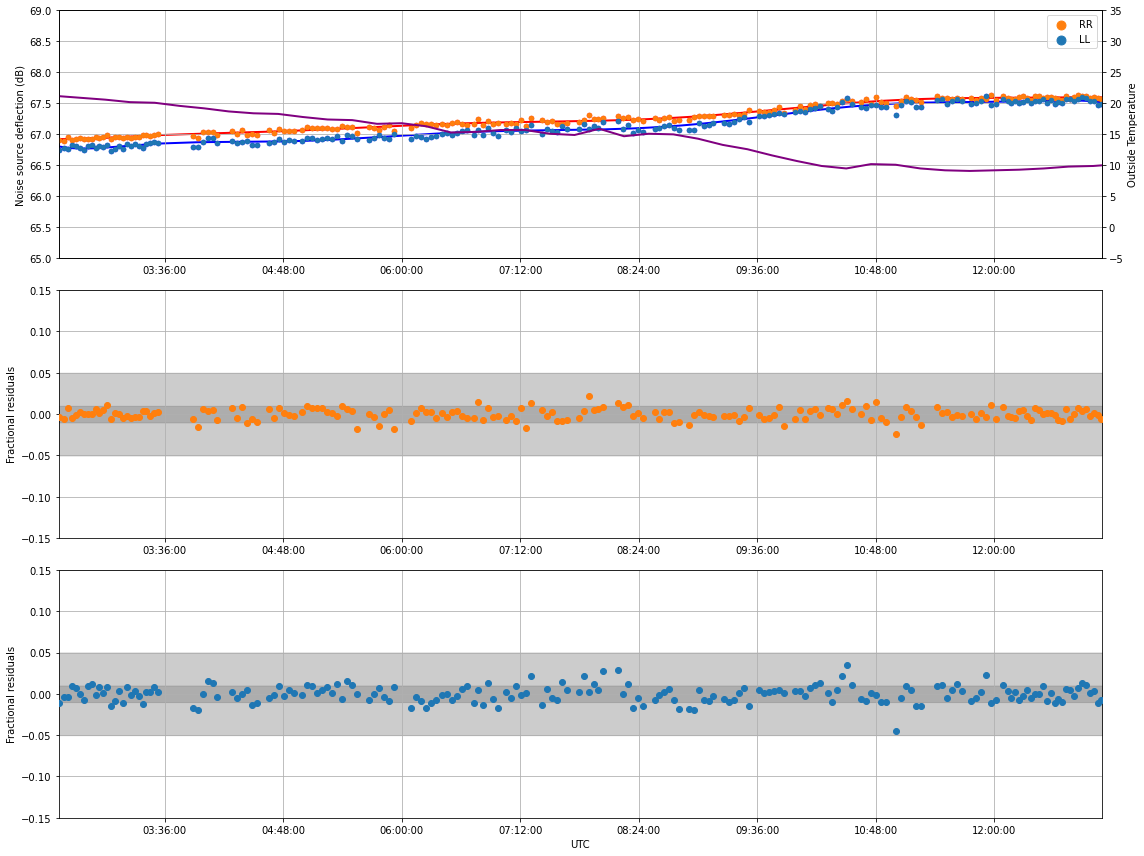

In [132]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(3,1,figsize=(16,12))

axs[0].scatter(t_noise,10*np.log10(RR_dnoise_arr[:,wf]),s=20,color='red')
axs[0].scatter(t_noise,10*np.log10(RR_dnoise_fix[:,wf]),s=20,color='C1',label='RR',zorder=10)
axs[0].scatter(t_noise,10*np.log10(LL_dnoise_arr[:,wf]),s=20,color='blue')
axs[0].scatter(t_noise,10*np.log10(LL_dnoise_fix[:,wf]),s=20,color='C0',label='LL',zorder=10)
axs[0].plot(t_set_plt,10*np.log10(LL_fit[:,wf]),color='blue',linewidth=2,zorder=0)
axs[0].plot(t_set_plt,10*np.log10(RR_fit[:,wf]),color='red',linewidth=2,zorder=0)
axs[0].set_ylim(65,69)
axs[0].set_ylabel('Noise source deflection (dB)')
axs[0].legend(markerscale=2)

ax2 = axs[0].twinx()
ax2.plot(t_weath_plt,temp_C,color='purple',linewidth=2)
ax2.set_ylim(-5,35)
ax2.set_ylabel('Outside Temperature')

axs[1].scatter(t_noise,(RR_dnoise_fix[:,wf]-RR_fit_noise_pt[:,wf])/RR_dnoise_fix[:,wf],
               color='C1',zorder=10)
axs[1].set_ylim(-0.15,0.15)
axs[1].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[1].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[1].set_ylabel('Fractional residuals')

axs[2].scatter(t_noise,(LL_dnoise_fix[:,wf]-LL_fit_noise_pt[:,wf])/LL_dnoise_fix[:,wf],
               color='C0',zorder=10)
axs[2].set_ylim(-0.15,0.15)
axs[2].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[2].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[2].set_ylabel('Fractional residuals')


for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlim(raster1_start_mjd[0],raster2_stop_mjd[-1])
    axs[i].grid()
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_deflection_fits_800MHz_phase'+phase+'_day'+day+'.png')

800.0208333333333


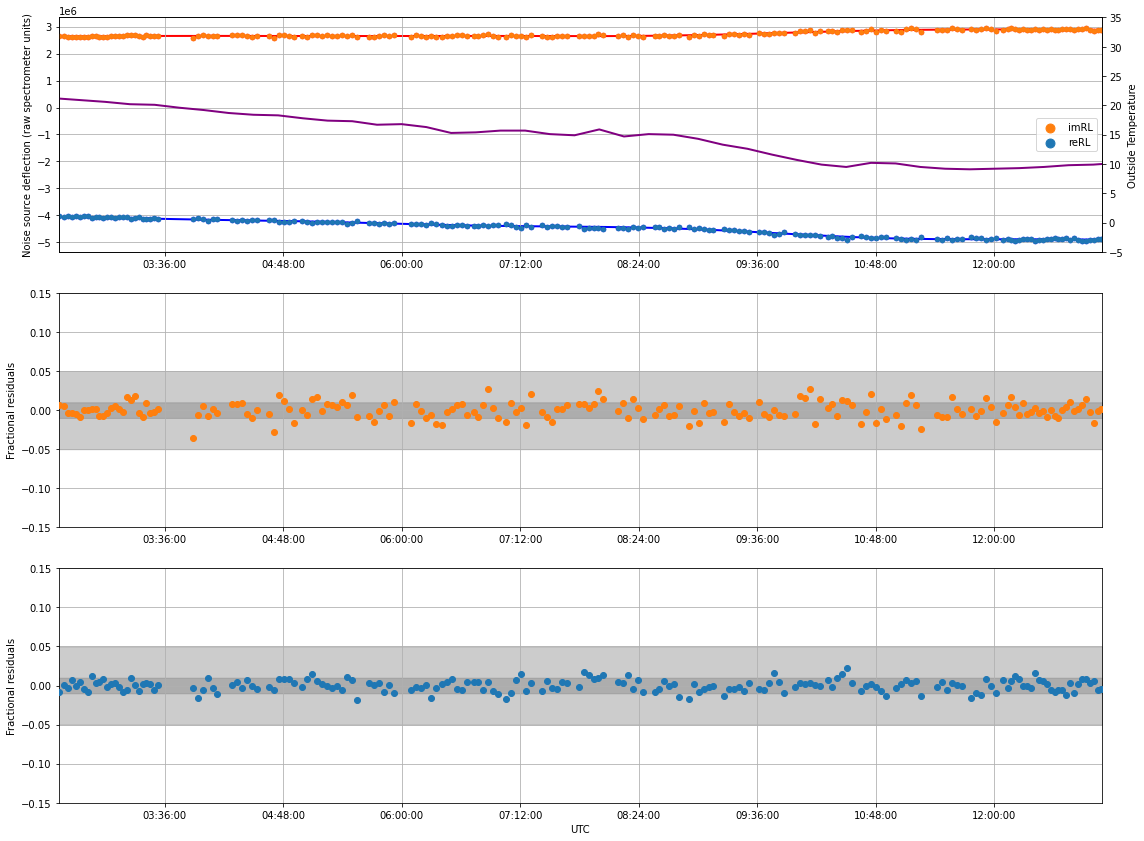

In [133]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(3,1,figsize=(16,12))

axs[0].scatter(t_noise,imRL_dnoise_arr[:,wf],s=20,color='red')
axs[0].scatter(t_noise,imRL_dnoise_fix[:,wf],s=20,color='C1',label='imRL',zorder=10)
axs[0].scatter(t_noise,reRL_dnoise_arr[:,wf],s=20,color='blue')
axs[0].scatter(t_noise,reRL_dnoise_fix[:,wf],s=20,color='C0',label='reRL',zorder=10)
axs[0].plot(t_set_plt,reRL_fit[:,wf],color='blue',linewidth=2,zorder=0)
axs[0].plot(t_set_plt,imRL_fit[:,wf],color='red',linewidth=2,zorder=0)
#axs[0].set_ylim(65,69)
axs[0].set_ylabel('Noise source deflection (raw spectrometer units)')
axs[0].legend(markerscale=2)

ax2 = axs[0].twinx()
ax2.plot(t_weath_plt,temp_C,color='purple',linewidth=2)
ax2.set_ylim(-5,35)
ax2.set_ylabel('Outside Temperature')

axs[1].scatter(t_noise,(imRL_dnoise_fix[:,wf]-imRL_fit_noise_pt[:,wf])/imRL_dnoise_fix[:,wf],
               color='C1',zorder=10)
axs[1].set_ylim(-0.15,0.15)
axs[1].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[1].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[1].set_ylabel('Fractional residuals')

axs[2].scatter(t_noise,(reRL_dnoise_fix[:,wf]-reRL_fit_noise_pt[:,wf])/reRL_dnoise_fix[:,wf],
               color='C0',zorder=10)
axs[2].set_ylim(-0.15,0.15)
axs[2].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[2].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[2].set_ylabel('Fractional residuals')


for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlim(raster1_start_mjd[0],raster2_stop_mjd[-1])
    axs[i].grid()
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_deflection_pol_fits_800MHz_phase'+phase+'_day'+day+'.png')

800.0208333333333


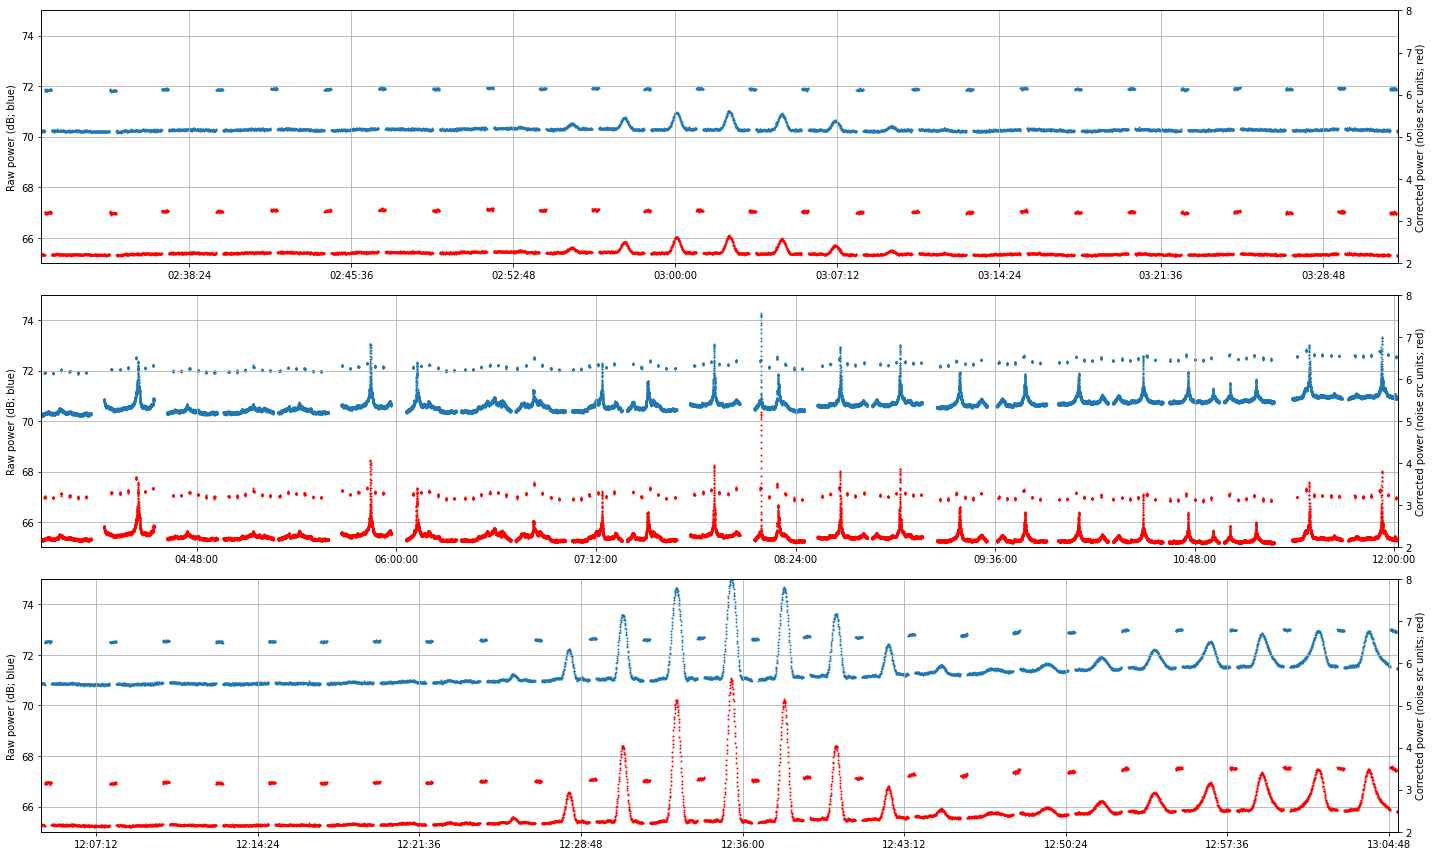

In [134]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])


lims_raw1 = [65,65,65]
lims_raw2 = [75,75,75]
lims_cor1 = [2,2,2]
lims_cor2 = [8,8,8]

sz=1
fig1, axs = plt.subplots(3,1,figsize=(20,12))

for i in range(0,3):
    axs[i].scatter(t_set_plt,10*np.log10(LL[:,wf]),s=sz)
    axs[i].set_ylim(lims_raw1[i],lims_raw2[i])
        
    ax2 = axs[i].twinx()
    ax2.scatter(t_set_plt,LL[:,wf]/LL_fit[:,wf],s=sz,color='red')
    ax2.set_ylim(lims_cor1[i],lims_cor2[i])
    ax2.set_ylabel('Corrected power (noise src units; red)')
    
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].grid()
    axs[i].set_ylabel('Raw power (dB; blue)')

axs[0].set_xlim(raster1_start_mjd[0],raster1_stop_mjd[-1])
#axs[0].set_xlim(raster1_start_mjd,raster1_start_mjd+0.005)
#axs[0].set_ylim(2e7,4e7)
axs[1].set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
#axs[1].set_ylim(1e7,10e7)
axs[2].set_xlim(raster2_start_mjd[0],raster2_stop_mjd[-1])
#axs[2].set_ylim(1e7,10e7)

plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/correction_example_LL_800MHz_phase'+phase+'_day'+day+'.png')

## Waterfall plot for power, gain and temperature:

800.0208333333333


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10


IndexError: index 53484 is out of bounds for axis 1 with size 53484

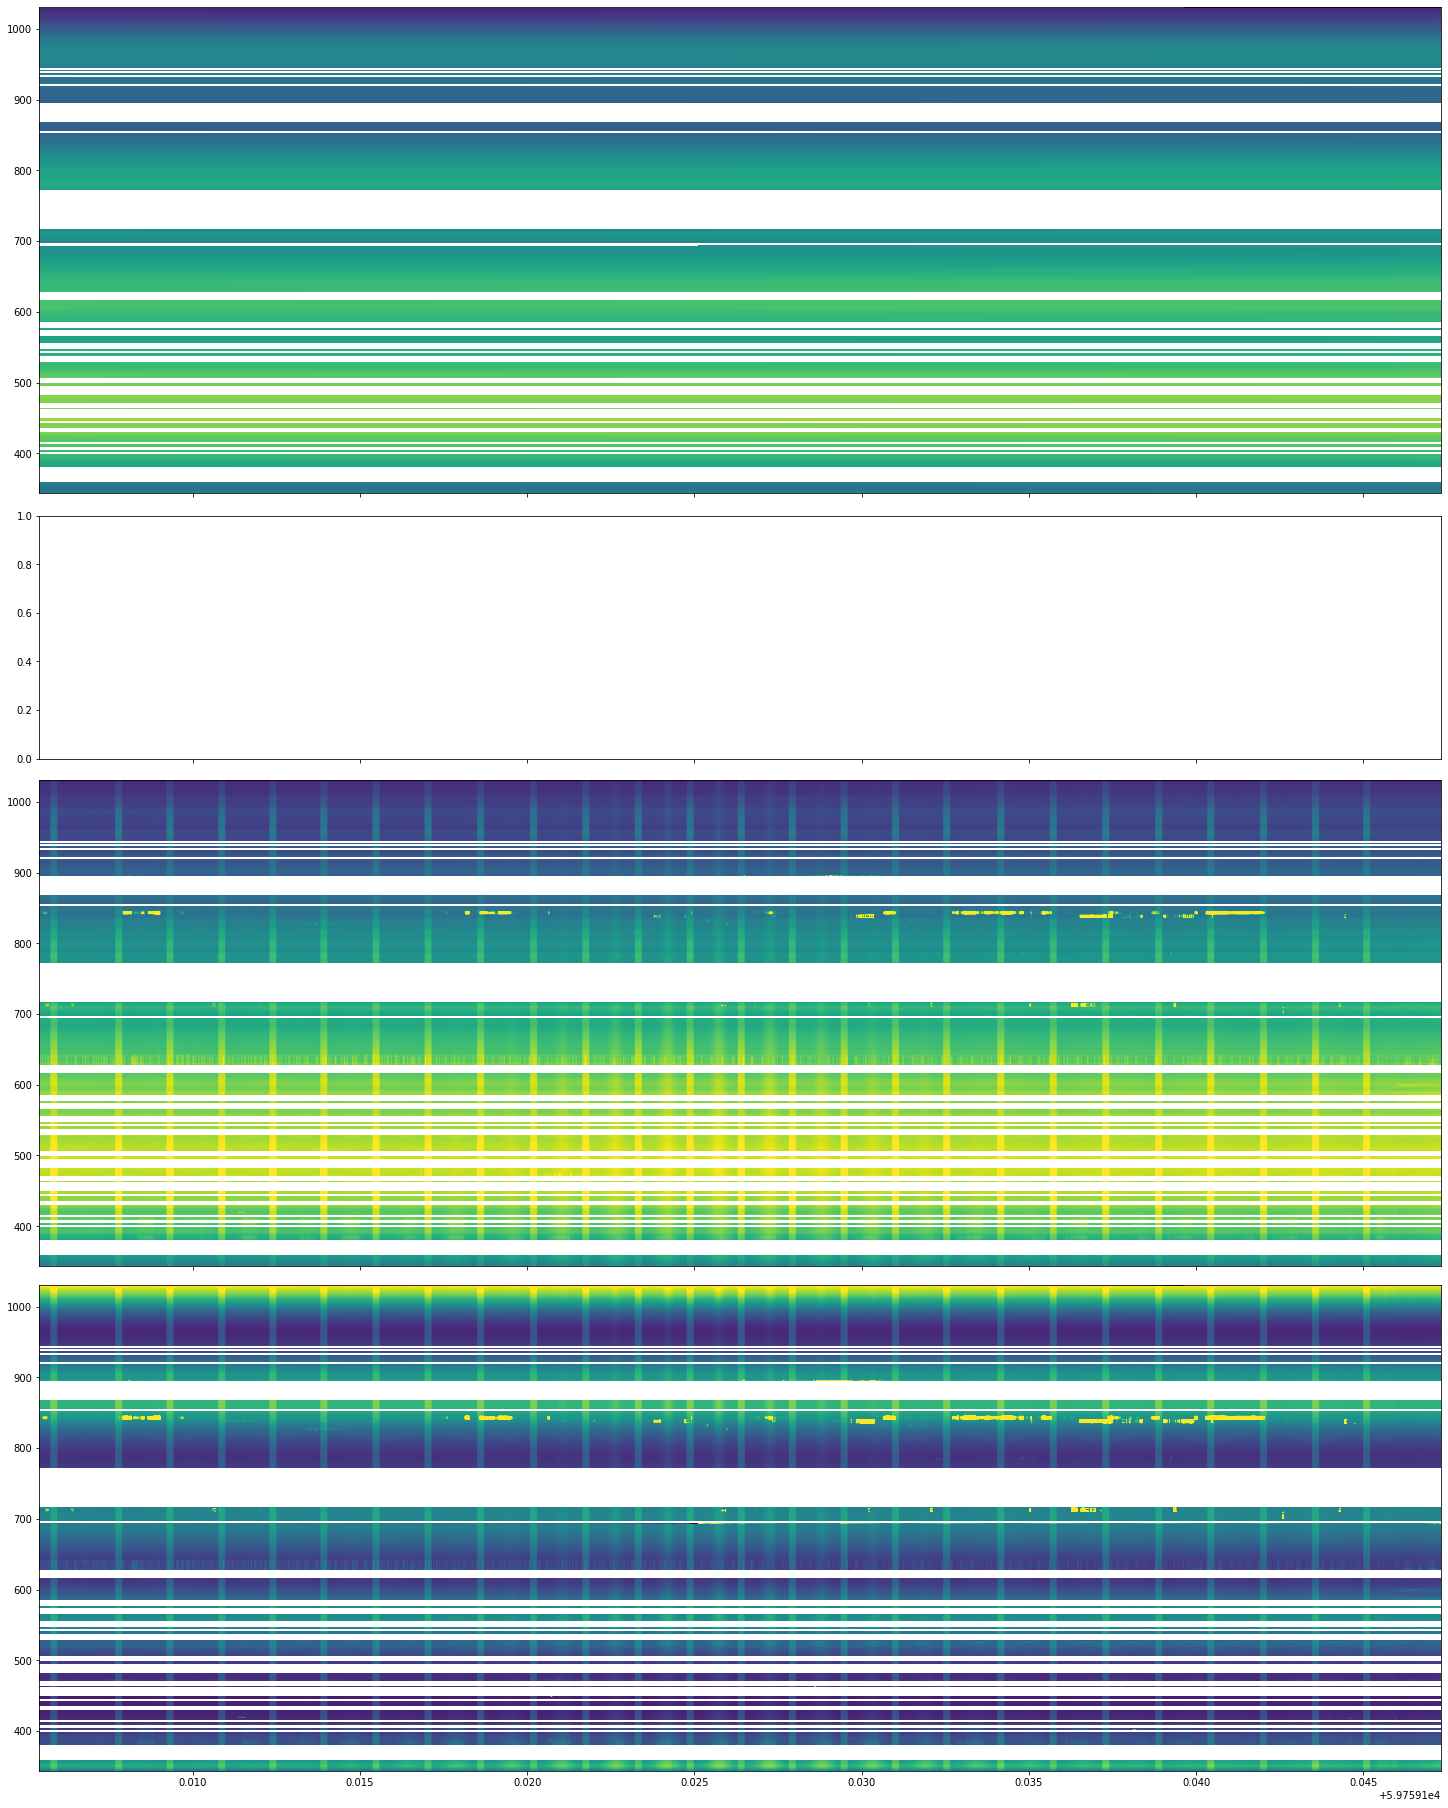

In [135]:
%%time

#Gmin = 0.9
#Gmax = 1.1
noisemin = 55
noisemax = 75
dBmin = 65
dBmax = 75

fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(4,1,figsize=(20,25),sharex=True,gridspec_kw={'height_ratios': [1,0.5,1,1]},
                         constrained_layout=True)
fs = 16

#data1 = LL.T
#data2 = LL_fit.T
data1[RFI_mask_idx,:] = np.nan
data2[RFI_mask_idx,:] = np.nan


for i in range(0,len(scan_id)):
    w = np.where((t_set_plt>=scan_start_mjd[i]) & (t_set_plt<=scan_stop_mjd[i]))[0]
    extent = [scan_start_mjd[i],scan_stop_mjd[i],freq[0],freq[-1]]
    
    im2 = axs[2].imshow(10*np.log10(data1[:,w]),aspect='auto',vmin=dBmin,vmax=dBmax,origin='lower',
                        extent=extent,cmap='viridis')    
    im0 = axs[0].imshow(10*np.log10(data2[:,w]),aspect='auto',vmin=noisemin,vmax=noisemax,origin='lower',
                        extent=extent,cmap='viridis')
    im3 = axs[3].imshow(data1[:,w]/data2[:,w],aspect='auto',vmin=1,vmax=8,origin='lower',
                        extent=extent,cmap='viridis')


for i in range(0,Ne):
    w = np.where((t_set_plt>=raster1_start_mjd[i]) & (t_set_plt<=raster1_stop_mjd[i]))[0]
    extent = [raster1_start_mjd[i],raster1_stop_mjd[i],freq[0],freq[-1]]

    im2 = axs[2].imshow(10*np.log10(data1[:,w]),aspect='auto',vmin=dBmin,vmax=dBmax,origin='lower',
                        extent=extent,cmap='viridis')    
    im0 = axs[0].imshow(10*np.log10(data2[:,w]),aspect='auto',vmin=noisemin,vmax=noisemax,origin='lower',
                        extent=extent,cmap='viridis')
    im3 = axs[3].imshow(data1[:,w]/data2[:,w],aspect='auto',vmin=1,vmax=8,origin='lower',
                        extent=extent,cmap='viridis')

for i in range(0,Nm):
    w = np.where((t_set_plt>=raster2_start_mjd[i]) & (t_set_plt<=raster2_stop_mjd[i]))[0]
    extent = [raster2_start_mjd[i],raster2_stop_mjd[i],freq[0],freq[-1]]

    im2 = axs[2].imshow(10*np.log10(data1[:,w]),aspect='auto',vmin=dBmin,vmax=dBmax,origin='lower',
                         extent=extent,cmap='viridis')    
    im0 = axs[0].imshow(10*np.log10(data2[:,w]),aspect='auto',vmin=noisemin,vmax=noisemax,origin='lower',
                         extent=extent,cmap='viridis')
    im3 = axs[3].imshow(data1[:,w]/data2[:,w],aspect='auto',vmin=1,vmax=8,origin='lower',
                        extent=extent,cmap='viridis')

cbar0= fig1.colorbar(im0,ax=axs[0])
cbar0.ax.tick_params(labelsize=fs) 
cbar0.set_label('Fitted noise source LL Power deflection (dB)', fontsize=fs)

cbar2= fig1.colorbar(im2,ax=axs[2])
cbar2.ax.tick_params(labelsize=fs) 
cbar2.set_label('LL Power (dB)', fontsize=fs)

cbar3= fig1.colorbar(im3,ax=axs[3])
cbar3.ax.tick_params(labelsize=fs) 
cbar3.set_label('LL Power (noise units)', fontsize=fs)

axs[1].plot(t_weath_plt,temp_C,color='purple',linewidth=3)
axs[1].set_ylim(-5,35)     
axs[1].set_ylabel('Temperature (C)',fontsize=fs)
axs[1].axvspan(raster1_start_mjd[0],raster1_stop_mjd[-1],color='C0',alpha=0.1)
axs[1].axvspan(raster2_start_mjd[0],raster2_stop_mjd[-1],color='C0',alpha=0.1)
ax2 = axs[1].twinx()
ax2.scatter(t_noise,10*np.log10(LL_dnoise_arr[:,wf]),s=10,color='red')
ax2.scatter(t_noise,10*np.log10(LL_dnoise_fix[:,wf]),s=10,color='k')
ax2.set_ylim(noisemin,noisemax)
ax2.set_ylabel('Noise source power (LL) at 800 MHz',fontsize=fs)
ax2.tick_params(axis='y', labelsize=fs)
for i in range(0,len(scan_id)):
    elhere = el[abs(t_set_plt-scan_start_mjd[i])<1e-4][0]
    if abs(elhere-49.32)<0.5:
        clr = 'C1'
    elif abs(elhere-20.0)<0.5:
        clr = 'C2'
    axs[1].axvspan(scan_start_mjd[i],scan_stop_mjd[i],color=clr,alpha=0.1)
axs[1].grid() 

for i in range(0,4):
    axs[i].set_xlim(t_set_plt[0],t_set_plt[-1])
    axs[i].tick_params(axis='both', labelsize=fs,labelbottom=True)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlabel('Time (UTC)',fontsize=fs)
    if i != 1:
        axs[i].set_ylim(freq[0],freq[-1])
        axs[i].set_ylabel('Frequency (MHz)',fontsize=fs)
    
#plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/waterfall_phase'+phase+'_day'+day+'.png')

## Checking frequency dependence

b'2022-06-29T06:32:57.600005Z'


/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


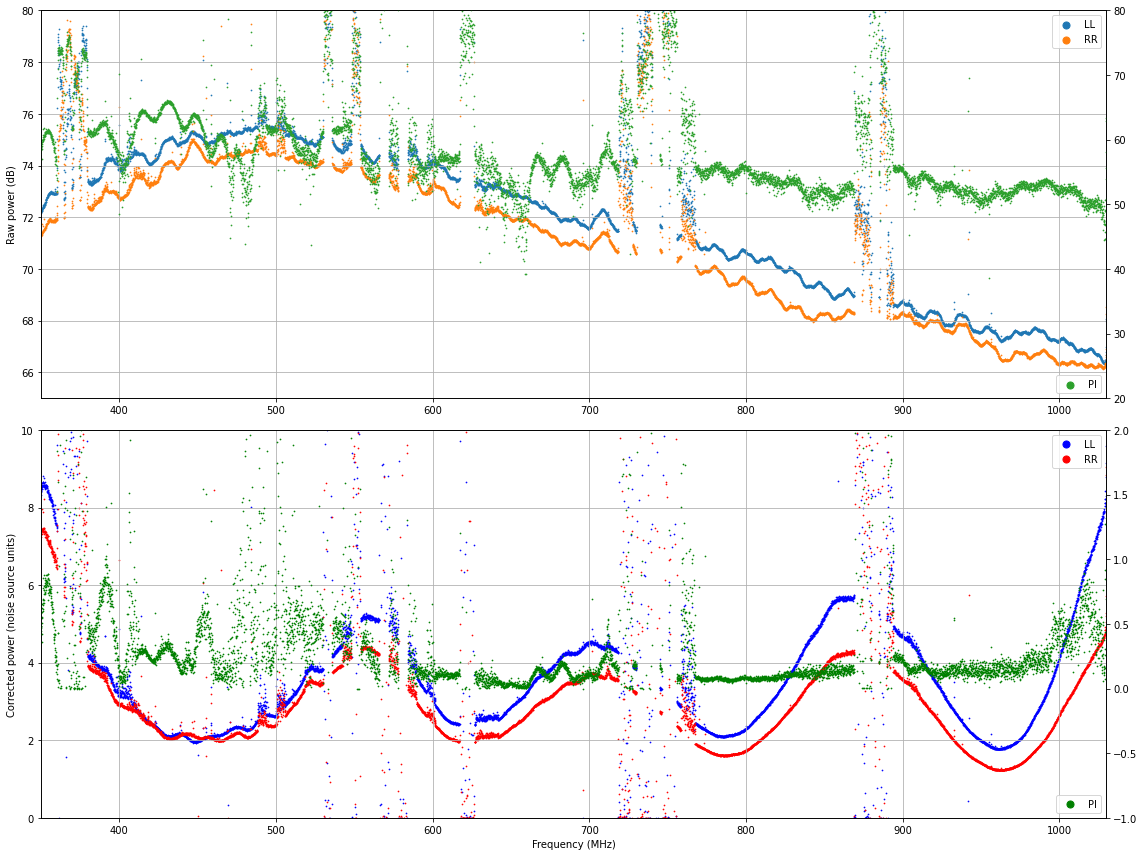

In [136]:
fig1, axs = plt.subplots(2,1,figsize=(16,12))

t_idx = 20000
print(t[t_idx])
s = 0.5

axs[0].scatter(freq,10*np.log10(LL[t_idx,:]),s=s,color='C0',label='LL')
axs[0].scatter(freq,10*np.log10(RR[t_idx,:]),s=s,color='C1',label='RR')
ax2 = axs[0].twinx()
ax2.scatter(freq,10*np.log10(np.sqrt((reRL[t_idx,:])**2+(imRL[t_idx])**2)),s=s,color='C2',label='PI')
axs[0].grid()
axs[0].set_ylim(65,80)
ax2.set_ylim(20,80)
axs[0].set_xlim(350,1030)
axs[0].set_ylabel('Raw power (dB)')
axs[0].legend(markerscale=10,loc='upper right')
ax2.legend(markerscale=10,loc='lower right')

axs[1].scatter(freq,LL[t_idx,:]/LL_fit[t_idx,:],s=s,color='blue',label='LL')
axs[1].scatter(freq,RR[t_idx,:]/RR_fit[t_idx,:],s=s,color='red',label='RR')
ax2 = axs[1].twinx()
ax2.scatter(freq,np.sqrt((reRL[t_idx,:]/reRL_fit[t_idx,:])**2+(imRL[t_idx]/imRL_fit[t_idx])**2),s=s,color='green',label='PI')
ax2.set_ylim(-1,2)
axs[1].set_ylim(0,10)
axs[1].grid()
axs[1].set_xlim(350,1030)
axs[1].set_ylabel('Corrected power (noise source units)')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].legend(markerscale=10,loc='upper right')
ax2.legend(markerscale=10,loc='lower right')

plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/correction_example_spectrum_phase'+phase+'_day'+day+'.png')

## Write out gain-corrected files

In [137]:
def write_gain_corrected(file,RR_out,LL_out,reRL_out,imRL_out,infiles,outfiles,inname,outname,GR,GL,GreRL,GimRL):

    cmd2 = 'cp '+infiles+inname+' '+outfiles+outname+'.h5'
    os.system(cmd2)
    file_new = h5py.File(outfiles+outname+'.h5','r+')
    
    print(inname)
    print(RR_out.shape)
    print(GR.shape)
    print(file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,0,:].shape)
    print('')
    
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,0,:] = RR_out/GR
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,1,:] = LL_out/GL
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,2,:] = reRL_out/GreRL
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,3,:] = imRL_out/GimRL
           
    file_new.close()

    
# Raster scan 1:
for i in range(0,Ne):   
    if Ne == 1:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster1_gain_corr'
    else:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'_gain_corr'
        
    file = h5py.File(dir_in_rast+inname,'r')

    write_gain_corrected(file,RR[idx1_rast1[i]:idx2_rast1[i],:],
                              LL[idx1_rast1[i]:idx2_rast1[i],:],
                            reRL[idx1_rast1[i]:idx2_rast1[i],:],
                            imRL[idx1_rast1[i]:idx2_rast1[i],:],
                         dir_in_rast,dir_out_rast,inname,outname,
                         RR_fit[idx1_rast1[i]:idx2_rast1[i],:],
                         LL_fit[idx1_rast1[i]:idx2_rast1[i],:],
                       reRL_fit[idx1_rast1[i]:idx2_rast1[i],:],
                       imRL_fit[idx1_rast1[i]:idx2_rast1[i],:])

# Raster scan 2:
for i in range(0,Nm):   
    if Nm == 1:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster2_gain_corr'
    else:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'_gain_corr'
        
    file = h5py.File(dir_in_rast+inname,'r')

    write_gain_corrected(file,RR[idx1_rast2[i]:idx2_rast2[i],:],
                              LL[idx1_rast2[i]:idx2_rast2[i],:],
                            reRL[idx1_rast2[i]:idx2_rast2[i],:],
                            imRL[idx1_rast2[i]:idx2_rast2[i],:],
                         dir_in_rast,dir_out_rast,inname,outname,
                         RR_fit[idx1_rast2[i]:idx2_rast2[i],:],
                         LL_fit[idx1_rast2[i]:idx2_rast2[i],:],
                       reRL_fit[idx1_rast2[i]:idx2_rast2[i],:],
                       imRL_fit[idx1_rast2[i]:idx2_rast2[i],:])



#file = h5py.File(dir_in_rast+inname,'r')
#w = np.where((t_set_plt >= rast2_file_t[0]) & (t_set_plt <= rast2_file_t[-1]))[0]
#write_gain_corrected(file,RR[w,:],LL[w,:],reRL[w,:],imRL[w,:],dir_in_rast,dir_out_rast,inname,outname,
#                     GL_fit[w],GR_fit[w])

dva_survey_phase1_day020_raster1.h5
(6400, 8250)
(6400, 8250)
(6400, 8250)



/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


dva_survey_phase1_day020_raster2.h5
(6400, 8250)
(6400, 8250)
(6400, 8250)



In [138]:
for i in scan_id:
    inname  = 'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'.h5'
    outname = 'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'_gain_corr'
    file = h5py.File(dir_in_az+inname,'r')
    print(i,file)
    t_az = Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][:],
                        format='isot',scale='utc').mjd
    w = np.where((t_set_plt >= t_az[0]) & (t_set_plt <= t_az[-1]))[0]
    print(w.shape)
    print('')
    write_gain_corrected(file,RR[w,:],LL[w,:],reRL[w,:],imRL[w,:],
                         dir_in_az,dir_out_az,inname,outname,
                         RR_fit[w,:],LL_fit[w,:],reRL_fit[w,:],imRL_fit[w,:])

835 <HDF5 file "dva_survey_phase1_raw_0835.h5" (mode r)>
(1803,)

dva_survey_phase1_raw_0835.h5
(1803, 8250)
(1803, 8250)
(1803, 8250)



/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/UBC-O/ashill01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


2348 <HDF5 file "dva_survey_phase1_raw_2348.h5" (mode r)>
(1804,)

dva_survey_phase1_raw_2348.h5
(1804, 8250)
(1804, 8250)
(1804, 8250)

1053 <HDF5 file "dva_survey_phase1_raw_1053.h5" (mode r)>
(1804,)

dva_survey_phase1_raw_1053.h5
(1804, 8250)
(1804, 8250)
(1804, 8250)

1054 <HDF5 file "dva_survey_phase1_raw_1054.h5" (mode r)>
(1804,)

dva_survey_phase1_raw_1054.h5
(1804, 8250)
(1804, 8250)
(1804, 8250)

1055 <HDF5 file "dva_survey_phase1_raw_1055.h5" (mode r)>
(1803,)

dva_survey_phase1_raw_1055.h5
(1803, 8250)
(1803, 8250)
(1803, 8250)

2568 <HDF5 file "dva_survey_phase1_raw_2568.h5" (mode r)>
(1803,)

dva_survey_phase1_raw_2568.h5
(1803, 8250)
(1803, 8250)
(1803, 8250)

1273 <HDF5 file "dva_survey_phase1_raw_1273.h5" (mode r)>
(1804,)

dva_survey_phase1_raw_1273.h5
(1804, 8250)
(1804, 8250)
(1804, 8250)

1274 <HDF5 file "dva_survey_phase1_raw_1274.h5" (mode r)>
(1804,)

dva_survey_phase1_raw_1274.h5
(1804, 8250)
(1804, 8250)
(1804, 8250)

1275 <HDF5 file "dva_survey_phase1_raw_12

In [117]:
del RR
del LL
del reRL
del imRL
del RR_fit
del LL_fit
del reRL_fit
del imRL_fit

gc.collect()

75

## Test new file by comparing to old file:

In [118]:
t_test = []
az_test = []
dec_test = []
ra_test = []
el_test = []
noise_test = []

# Use one of the scans to get the list of frequencies:
scan0 = f"{scan_id[0]:04}"
file_test = h5py.File(dir_out_az+'dva_survey_phase'+phase+'_raw_'+scan0+'_gain_corr.h5','r')
freq_test = file_test['data']['beam_0']['band_SB0']['frequency'][:]/1e6

# Create empty arrays for the power data:
RR_test = np.empty([0,len(freq_test)])
LL_test = np.empty([0,len(freq_test)])
reRL_test = np.empty([0,len(freq_test)])
imRL_test = np.empty([0,len(freq_test)])

# Raster scan 1:
for i in range(0,Ne):
    if Ne == 1:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+'_gain_corr.h5','r')
    else:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'_gain_corr.h5','r')

    rast1_file_t_test = [Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                            format='isot',scale='utc').mjd,
                        Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                            format='isot',scale='utc').mjd]
    RR_test,LL_test,reRL_test,imRL_test,dec_test,ra_test,el_test,az_test,t_test,noise_test,idx1_test,idx2_test = concatenate_data(file_test,RR_test,LL_test,reRL_test,imRL_test,
                                                            dec_test,ra_test,el_test,az_test,t_test,noise_test)


# Loop through all the scans in the "scan_num" list:
for i in scan_id:
    file_test = h5py.File(dir_out_az+'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'_gain_corr.h5','r')
    print(i,file_test)
    RR_test,LL_test,reRL_test,imRL_test,dec_test,ra_test,el_test,az_test,t_test,noise_test,idx1_test,idx2_test = concatenate_data(file_test,RR_test,LL_test,reRL_test,imRL_test,
                                                            dec_test,ra_test,el_test,az_test,t_test,noise_test)

# Raster scan 2:
for i in range(0,Nm):
    if Nm == 1:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+'_gain_corr.h5','r')
    else:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'_gain_corr.h5','r')

    rast2_file_t_test = [Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                            format='isot',scale='utc').mjd,
                        Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                            format='isot',scale='utc').mjd]
    RR_test,LL_test,reRL_test,imRL_test,dec_test,ra_test,el_test,az_test,t_test,noise_test,idx1_test,idx2_test = concatenate_data(file_test,RR_test,LL_test,reRL_test,imRL_test,
                                                            dec_test,ra_test,el_test,az_test,t_test,noise_test)


t_test_plt = Time(t_test, format='isot',scale='utc').mjd


2850 <HDF5 file "dva_survey_phase1_raw_2850_gain_corr.h5" (mode r)>
2851 <HDF5 file "dva_survey_phase1_raw_2851_gain_corr.h5" (mode r)>
2852 <HDF5 file "dva_survey_phase1_raw_2852_gain_corr.h5" (mode r)>
119 <HDF5 file "dva_survey_phase1_raw_0119_gain_corr.h5" (mode r)>
120 <HDF5 file "dva_survey_phase1_raw_0120_gain_corr.h5" (mode r)>
1633 <HDF5 file "dva_survey_phase1_raw_1633_gain_corr.h5" (mode r)>
1634 <HDF5 file "dva_survey_phase1_raw_1634_gain_corr.h5" (mode r)>
339 <HDF5 file "dva_survey_phase1_raw_0339_gain_corr.h5" (mode r)>
340 <HDF5 file "dva_survey_phase1_raw_0340_gain_corr.h5" (mode r)>
1853 <HDF5 file "dva_survey_phase1_raw_1853_gain_corr.h5" (mode r)>
558 <HDF5 file "dva_survey_phase1_raw_0558_gain_corr.h5" (mode r)>
559 <HDF5 file "dva_survey_phase1_raw_0559_gain_corr.h5" (mode r)>
632 <HDF5 file "dva_survey_phase1_raw_0632_gain_corr.h5" (mode r)>
633 <HDF5 file "dva_survey_phase1_raw_0633_gain_corr.h5" (mode r)>
2146 <HDF5 file "dva_survey_phase1_raw_2146_gain_corr.h5

800.0208333333333


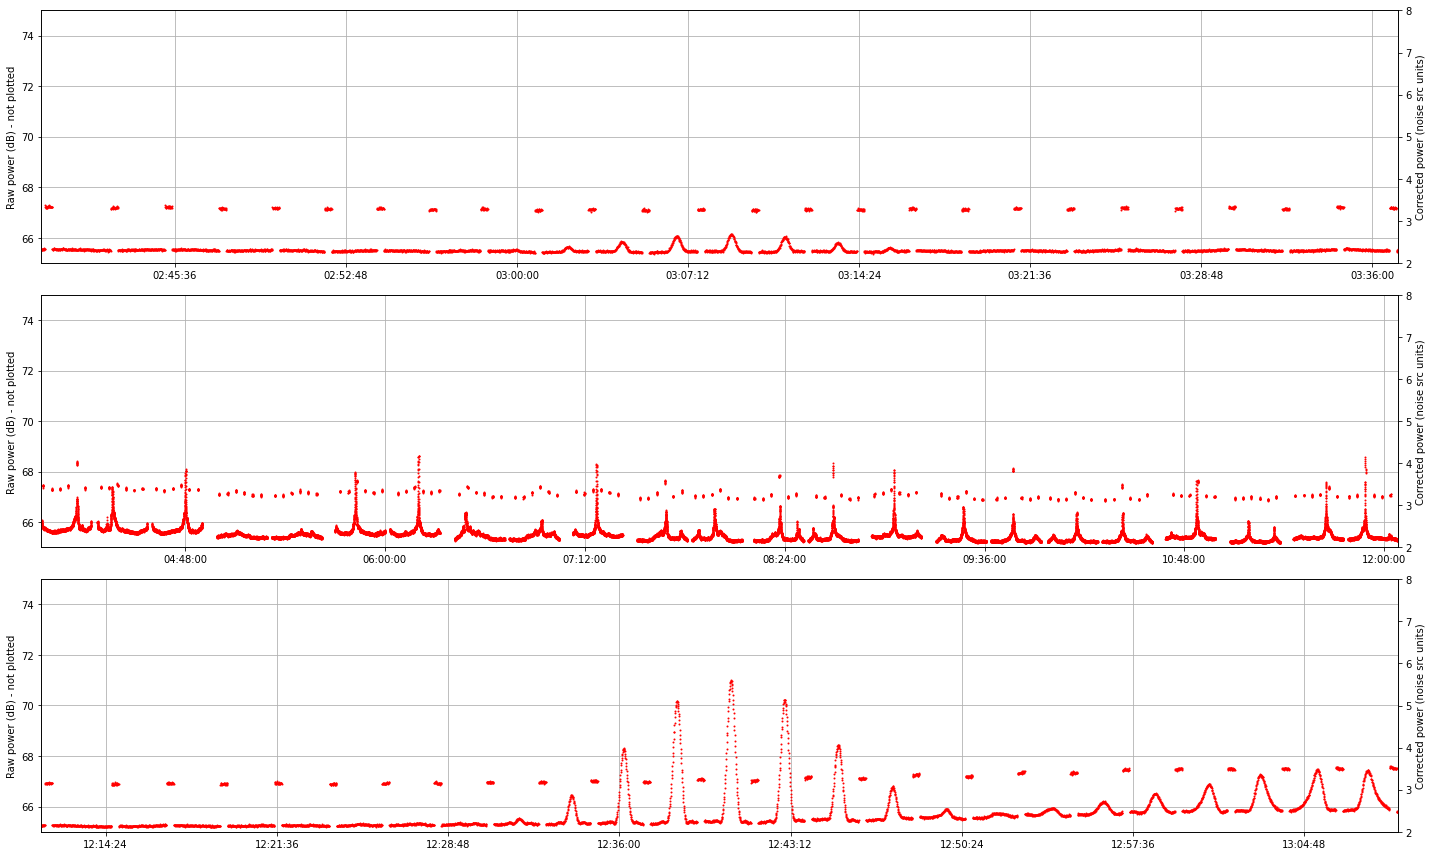

In [119]:
fplot = 800
df = freq_test[1]-freq_test[0]
wf = np.where(abs(freq_test-fplot)<df/2)[0][0]
print(freq_test[wf])

lims_raw1 = [65,65,65]
lims_raw2 = [75,75,75]
lims_cor1 = [2,2,2]
lims_cor2 = [8,8,8]

sz=1
fig1, axs = plt.subplots(3,1,figsize=(20,12))

for i in range(0,3):
    axs[i].scatter(t_test_plt,LL_test[:,wf],s=sz,color='red',alpha=0)
    axs[i].set_ylim(lims_raw1[i],lims_raw2[i])
        
    ax2 = axs[i].twinx()
    ax2.scatter(t_test_plt,LL_test[:,wf],s=sz,color='red')
    ax2.set_ylim(lims_cor1[i],lims_cor2[i])
    axs[i].set_ylabel('Raw power (dB) - not plotted')
    
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].grid()
    ax2.set_ylabel('Corrected power (noise src units)')

axs[0].set_xlim(raster1_start_mjd[0],raster1_stop_mjd[-1])
#axs[0].set_xlim(raster1_start_mjd,raster1_start_mjd+0.005)
#axs[0].set_ylim(2e7,4e7)
axs[1].set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
#axs[1].set_ylim(1e7,10e7)
axs[2].set_xlim(raster2_start_mjd[0],raster2_stop_mjd[-1])
#axs[2].set_ylim(1e7,10e7)

plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/correction_example_LL_800MHz_phase'+phase+'_day'+day+'_test.png')